# Parameter estimation by optimization

## How often do we get no-hitters?  

Number of no-hitters per season (Poisson Process)

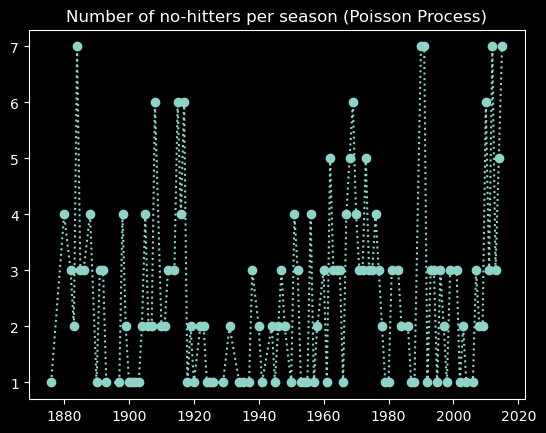

In [81]:
# %matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
plt.style.use('dark_background')
# sns.set()
nohitter = pd.read_csv('mlb_nohitters.zip', parse_dates=['date'], index_col=['date'])
nohitter_times = nohitter.groupby(nohitter.index.year).game_number.count()
plt.plot(nohitter_times, marker='o', linestyle='dotted')
plt.title('Number of no-hitters per season (Poisson Process)')
plt.show()

## No-hitters interval
The number of games played between each no-hitter in the modern era (1901-2015) of Major League Baseball is an exponential distribution.

In [82]:
nohitter_interval = nohitter.loc['1900':'2015','game_number'].diff().dropna() - 1
nohitter_interval.head()

date
1901-07-15     843.0
1902-09-20    1613.0
1903-09-18    1101.0
1904-05-05     215.0
1904-08-17     684.0
Name: game_number, dtype: float64

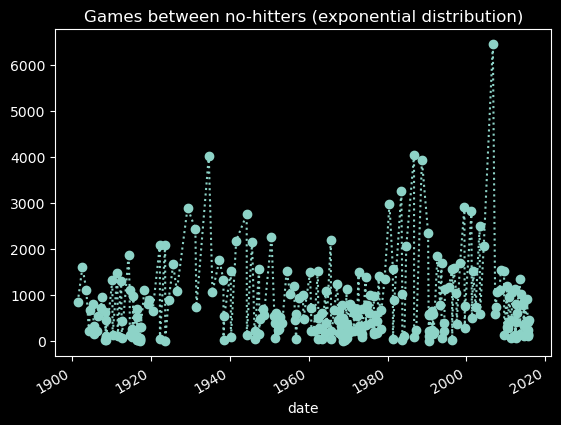

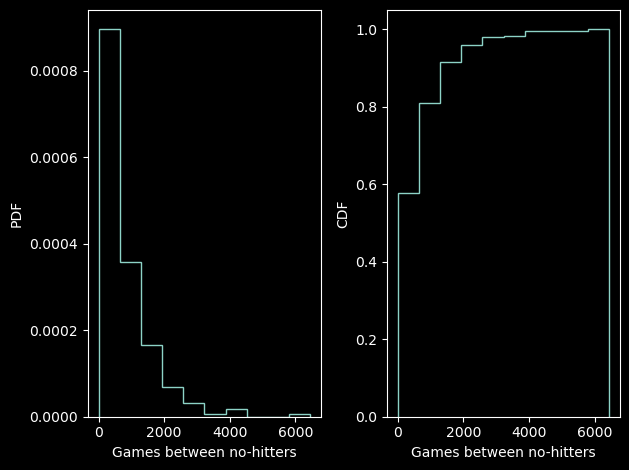

In [83]:
nohitter_interval.plot(marker='o', linestyle='dotted', title='Games between no-hitters (exponential distribution)')
plt.show()
plt.subplot(1,2,1)
_ = plt.hist(nohitter_interval, density=True, histtype='step')
_ = plt.xlabel('Games between no-hitters')
_ = plt.ylabel('PDF')
plt.subplot(1,2,2)
_ = plt.hist(nohitter_interval, density=True, cumulative=True, histtype='step')
_ = plt.xlabel('Games between no-hitters')
_ = plt.ylabel('CDF')
plt.tight_layout()

## Exponential simulation
If you assume that no-hitters are described as a Poisson process, then the time between no-hitters is Exponentially distributed.

As you have seen, the Exponential distribution has a single parameter, which we will call $\tau$ (tau), the typical interval time.

The value of the parameter **$\tau$** that makes the exponential distribution best match the data is the mean interval time (where time is in units of number of games) between no-hitters.

The following simulates the history of Major League Baseball by drawing inter-no-hitter times from an exponential distribution with the $\tau$ you found and plot the histogram as an approximation to the PDF.

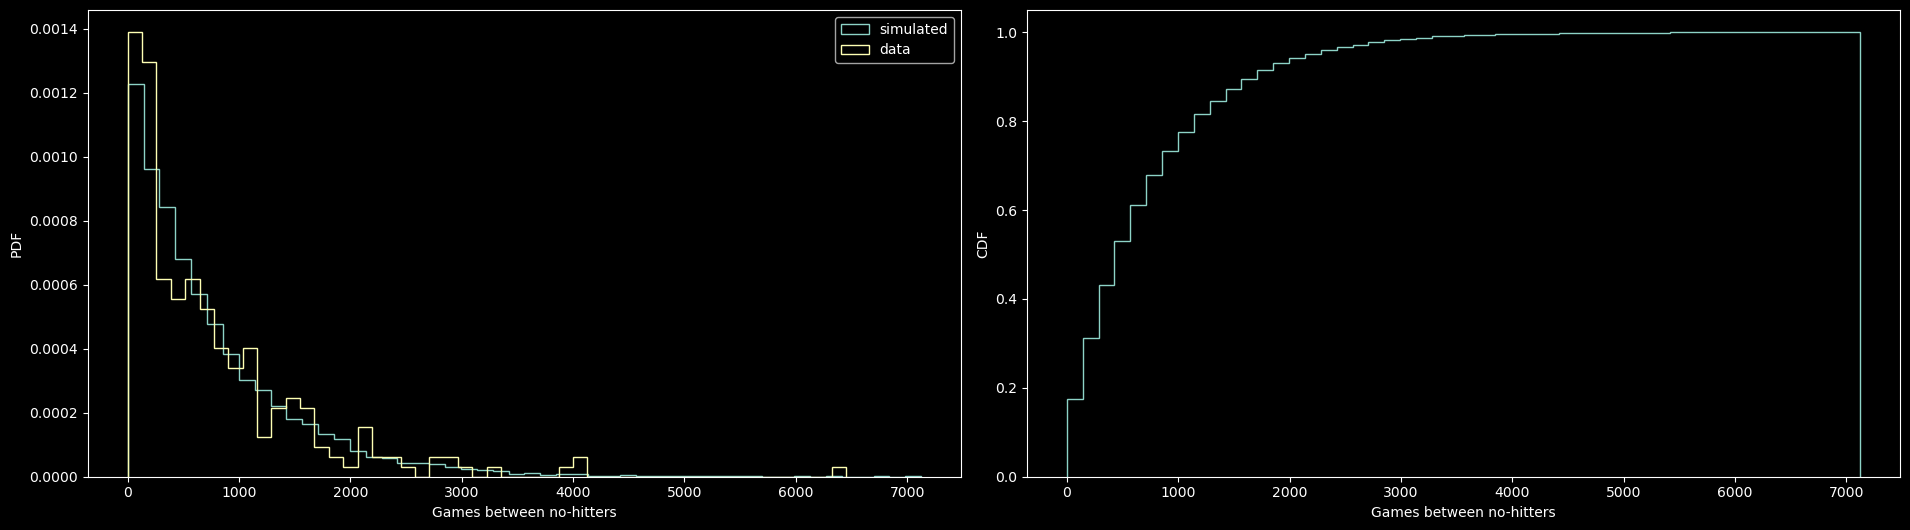

In [84]:
tau = nohitter_interval.mean()
sim_nohitter_interval = np.random.exponential(scale=tau, size=10000)

plt.figure(figsize=(19.2,10.8/2))
plt.subplot(1,2,1)
plt.hist(sim_nohitter_interval, density=True, histtype='step', bins=50, label='simulated')
plt.hist(nohitter_interval, density=True, histtype='step', bins=50, label='data')
plt.xlabel('Games between no-hitters')
plt.ylabel('PDF')
plt.legend()

plt.subplot(1,2,2)
plt.hist(sim_nohitter_interval, density=True, cumulative=True, histtype='step', bins=50)
plt.xlabel('Games between no-hitters')
plt.ylabel('CDF')
plt.tight_layout()

## Comparing ECDF from real and simulated data

In [85]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)
    # x-data for the ECDF: x
    x = np.sort(data)
    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n
    return x, y

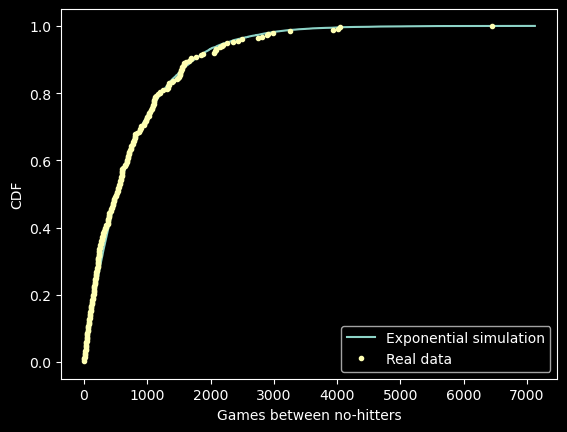

In [86]:
plt.plot(*ecdf(sim_nohitter_interval))
plt.plot(*ecdf(nohitter_interval), marker='.', linestyle='none')
plt.xlabel('Games between no-hitters')
plt.ylabel('CDF')
plt.legend(['Exponential simulation', 'Real data'], loc='lower right')
plt.show()

It looks like no-hitters in the modern era of Major League Baseball are Exponentially distributed. Based on the story of the Exponential distribution, this suggests that they are a random process; when a no-hitter will happen is independent of when the last no-hitter was.

## How is this parameter optimal?
Sampling out of an exponential distribution with $\tau$ being twice and also half as large as the optimal $\tau$ and make CDFs of these samples and overlay them with your data.

You can see that they do not reproduce the data as well.

Thus, the $\tau$ you computed from the mean inter-no-hitter times is optimal in that it best reproduces the data.

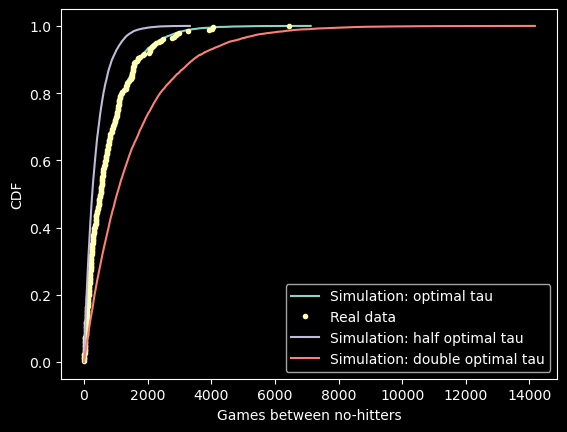

In [87]:

plt.plot(*ecdf(sim_nohitter_interval))
plt.xlabel('Games between no-hitters')
plt.ylabel('CDF')

plt.plot(*ecdf(nohitter_interval), marker='.', linestyle='none')

samples_half = np.random.exponential(tau/2, size=10000)
plt.plot(*ecdf(samples_half))

samples_double = np.random.exponential(2*tau, size=10000)
plt.plot(*ecdf(samples_double))
plt.legend(['Simulation: optimal tau', 'Real data', 'Simulation: half optimal tau', 'Simulation: double optimal tau'], loc='lower right')

plt.show()

Notice how the value of tau given by the mean matches the data best. In this way, tau is an optimal parameter.

## Linear Regression by Least Squares

### EDA of literacy/fertility data
In the next few exercises, we will look at the correlation between female **literacy** and **fertility** (defined as the average number of children born per woman) throughout the world.

For ease of analysis and interpretation, we will work with the **illiteracy rate**.

It is always a good idea to do some EDA ahead of our analysis. To this end, plot the fertility versus illiteracy and compute the Pearson correlation coefficient.

In [88]:
female = pd.read_csv('female_literacy_fertility.zip')
female.info()
female.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 0 to 161
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Country          162 non-null    object 
 1   Continent        162 non-null    object 
 2   female literacy  162 non-null    float64
 3   fertility        162 non-null    float64
 4   population       162 non-null    object 
dtypes: float64(2), object(3)
memory usage: 6.5+ KB


,Country,Continent,female literacy,fertility,population
0,Chine,ASI,90.5,1.769,"1,324,655,000"
1,Inde,ASI,50.8,2.682,"1,139,964,932"
2,USA,NAM,99.0,2.077,"304,060,000"
3,Indonésie,ASI,88.8,2.132,"227,345,082"
4,Brésil,LAT,90.2,1.827,"191,971,506"


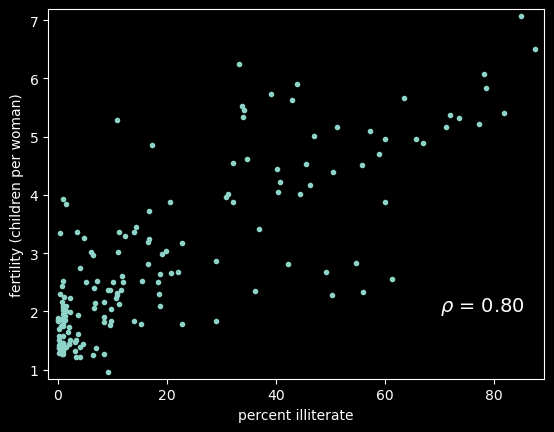

In [89]:
female['illiteracy'] = 100 - female['female literacy']
plt.plot(female.illiteracy, female.fertility, marker='.', linestyle='none')

# Set the margins and label axes
plt.margins(.02)
_ = plt.xlabel('percent illiterate')
_ = plt.ylabel('fertility (children per woman)')
_ = plt.annotate('$\\rho$ = {:.2f}'.format(np.corrcoef(female.illiteracy, female.fertility)[0,1]), xy=((70,2)), size=14)

You can see the correlation between illiteracy and fertility by eye, and by the substantial Pearson correlation coefficient of 0.8.

It is difficult to resolve in the scatter plot, but there are many points around near-zero illiteracy and about 1.8 children/woman.

### Linear regression
We will assume that fertility is a linear function of the female illiteracy rate $i$.

That is, $f = a i + b$, where a is the slope and b is the intercept.

We can think of the **intercept** as the minimal fertility rate, probably somewhere between one and two.

The **slope** tells us how the fertility rate varies with illiteracy. We can find the best fit line using `np.polyfit()`.

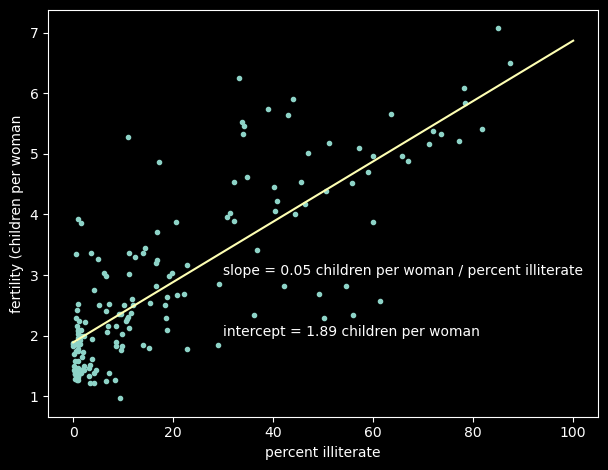

In [90]:
plt.plot(female.illiteracy, female.fertility, marker='.', linestyle='none')
plt.xlabel('percent illiterate')
plt.ylabel('fertility (children per woman')
slope, intercept = np.polyfit(female.illiteracy, female.fertility, deg=1)
plt.annotate(f'slope = {slope:.2f} children per woman / percent illiterate', xy=(30,3))
plt.annotate(f'intercept = {intercept:.2f} children per woman', xy=(30,2))

# Make theoretical line to plot
x = np.array([0,100])
y = slope * x + intercept
plt.plot(x, y)
plt.tight_layout()

### How is it optimal?
The function `np.polyfit()` that you used to get your regression parameters finds the optimal slope and intercept.

It is optimizing the sum of the squares of the residuals, also known as **RSS** (for residual sum of squares).

$$RSS = \sum_{i=1}^{n}(y_i - \hat{y_i})^2$$

In this exercise, you will plot the function that is being optimized, the **RSS**, versus the slope parameter $a$, holding constant the intercept $b$.

To do this, fix the intercept to be what you found in the regression.

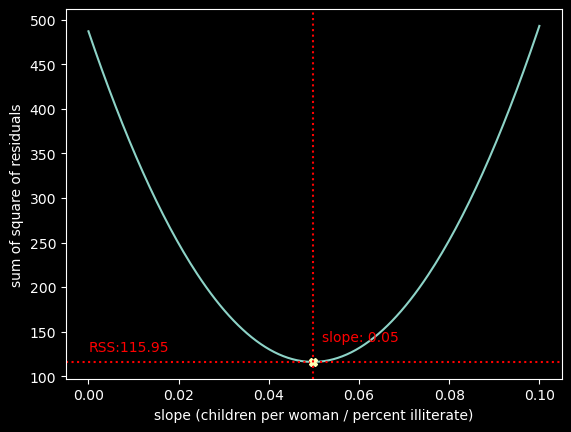

In [91]:
# Specify slopes to consider: a_vals
slopes = np.linspace(0, 0.1, 200)

# Initialize sum of square of residuals: rss
rss = np.empty_like(slopes)

# Compute sum of square of residuals for each value of a_vals
for i, a in enumerate(slopes):
    rss[i] = np.sum(
        (  female.fertility - (a * female.illiteracy + intercept)  ) **2 )

# Plot the RSS
_ = plt.plot(slopes, rss, '-')
plt.xlabel('slope (children per woman / percent illiterate)')
plt.ylabel('sum of square of residuals')

# plot annotations
minrss = np.sum((female.fertility - (slope * female.illiteracy + intercept))**2)
_ = plt.axhline(minrss, linestyle='dotted', color='red')
_ = plt.plot(slope, minrss, marker='X')
_ = plt.annotate('RSS:{:.2f}'.format(minrss), xy=(0, minrss*1.1), color='red')
_ = plt.axvline(slope, linestyle='dotted', color='red')
_ = plt.annotate('slope: {:.2f}'.format(slope), xy=(slope*1.04, minrss*1.2), color='red')

Notice that the minimum on the plot, that is the value of the slope that gives the minimum RSS (sum of the square of the residuals), is the same value you got when performing the regression with `np.polyfit()`.

## Anscombe's quartet

> Anscombe's quartet comprises four data sets that have nearly identical simple descriptive statistics, yet have very different distributions and appear very different when graphed. Each dataset consists of eleven (x,y) points. They were constructed in 1973 by the statistician Francis Anscombe to demonstrate both the importance of graphing data when analyzing it, and the effect of outliers and other influential observations on statistical properties. He described the article as being intended to counter the impression among statisticians that "numerical calculations are exact, but graphs are rough."

In [92]:
anscombe = pd.read_csv('anscombe.zip', skiprows=1)
anscombe.columns = ['x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4']
anscombe.info()
anscombe.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      11 non-null     float64
 1   y1      11 non-null     float64
 2   x2      11 non-null     float64
 3   y2      11 non-null     float64
 4   x3      11 non-null     float64
 5   y3      11 non-null     float64
 6   x4      11 non-null     float64
 7   y4      11 non-null     float64
dtypes: float64(8)
memory usage: 832.0 bytes


,x1,y1,x2,y2,x3,y3,x4,y4
count,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000
mean,9.000000,7.500909,9.000000,7.500909,9.000000,7.500000,9.000000,7.500909
std,3.316625,2.031568,3.316625,2.031657,3.316625,2.030424,3.316625,2.030579
min,4.000000,4.260000,4.000000,3.100000,4.000000,5.390000,8.000000,5.250000
25%,6.500000,6.315000,6.500000,6.695000,6.500000,6.250000,8.000000,6.170000
50%,9.000000,7.580000,9.000000,8.140000,9.000000,7.110000,8.000000,7.040000
75%,11.500000,8.570000,11.500000,8.950000,11.500000,7.980000,8.000000,8.190000
max,14.000000,10.840000,14.000000,9.260000,14.000000,12.740000,19.000000,12.500000


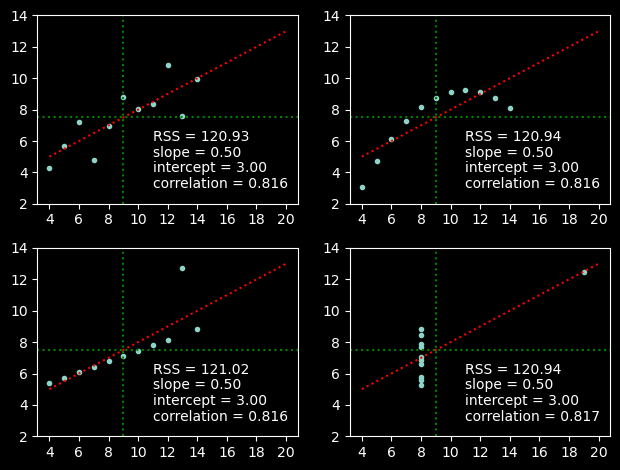

In [93]:
slopes=np.arange(4, 21)
for i in range(1,5):
    plt.subplot(2,2,i)
    plt.scatter(f'x{i}', f'y{i}', data=anscombe, marker='.')
    plt.axvline(anscombe[f'x{i}'].mean(), color='green', linestyle='dotted')
    plt.axhline(anscombe[f'y{i}'].mean(), color='green', linestyle='dotted')
    slope, intercept = np.polyfit(anscombe[f'x{i}'], anscombe[f'y{i}'], deg=1)
    _ = plt.plot(slopes, slopes * slope + intercept, color='red', linestyle='dotted')
    plt.annotate('RSS = {:.2f}'.format(np.sum((anscombe[f'x{i}'] - slope * anscombe[f'y{i}'] - intercept)**2)), xy=(11,6))
    plt.annotate('slope = {:.2f}'.format(slope), xy=(11, 5))
    plt.annotate('intercept = {:.2f}'.format(intercept), xy=(11, 4))
    plt.annotate('correlation = {:.3f}'.format(np.corrcoef(anscombe[f'x{i}'], anscombe[f'y{i}'])[0,1]), xy=(11,3))
    plt.xticks(np.arange(4, 21, 2))
    plt.yticks(np.arange(2, 15, 2))
plt.tight_layout()

# Boostrap confidence intervals

## Visualizing bootstrap samples
In this exercise, you will generate bootstrap samples from the set of annual rainfall data measured at the Sheffield Weather Station in the UK from 1883 to 2015.

The data are stored in the NumPy array rainfall in units of millimeters (mm).

By graphically displaying the bootstrap samples with an ECDF, you can get a feel for how bootstrap sampling allows probabilistic descriptions of data.

In [94]:
rainfall=pd.read_csv('sheffield_weather_station.zip', skiprows=8, delim_whitespace=True)
rainfall.info()
rainfall.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1602 entries, 0 to 1601
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   yyyy    1602 non-null   int64  
 1   mm      1602 non-null   int64  
 2   tmax    1602 non-null   object 
 3   tmin    1602 non-null   object 
 4   af      1602 non-null   object 
 5   rain    1602 non-null   float64
 6   sun     1602 non-null   object 
dtypes: float64(1), int64(2), object(4)
memory usage: 87.7+ KB


,yyyy,mm,tmax,tmin,af,rain,sun
0,1883,1,6.3,1.7,6,122.1,---
1,1883,2,8.0,2.8,2,69.8,---
2,1883,3,4.8,-1.6,23,29.6,---
3,1883,4,12.2,3.8,2,74.0,---
4,1883,5,14.7,6.2,0,31.2,---


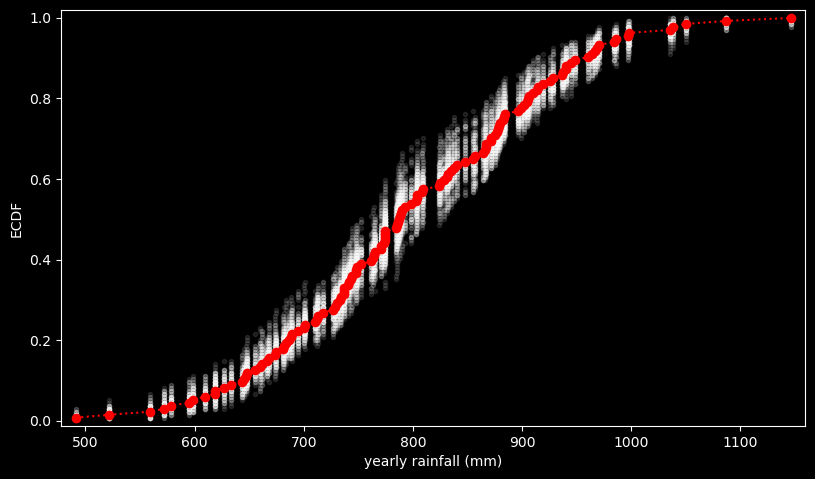

In [95]:
yearly_rain = rainfall.rain.groupby(rainfall.yyyy).sum()
plt.figure(figsize=(19.2/2, 10.8/2))
for _ in range(100):
    # Generate bootstrap sample: bs_sample
    bs_sample = np.random.choice(yearly_rain, size=len(yearly_rain))
    # Compute and plot ECDF from bootstrap sample
    x, y = ecdf(bs_sample)
    plt.plot(x, y,  marker='.', linestyle='none', color='white', alpha=0.1)

# Compute and plot ECDF from original data
x, y = ecdf(yearly_rain)
plt.plot(x, y, marker='o', color='red', linestyle=':')

# Make margins and label axes
plt.margins(0.02)
_ = plt.xlabel('yearly rainfall (mm)')
_ = plt.ylabel('ECDF')

Notice how the white points (bootstrap samples) give an idea of how the distribution of rainfalls is spread.

## Boostrap replicate function

In [96]:
# def draw_bs_reps(data, func, size=1):
#     """Draw bootstrap replicates."""
#     import numpy as np
#     bs_replicates = np.empty(size)
#     for i in range(size):
#         bs_replicates[i] = func(np.random.choice(data, len(data)))
#     return bs_replicates

def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""
    return np.array([func(np.random.choice(data, len(data))) for i in range(size)])

## Bootstrap replicates of the mean and the SEM
In this exercise, you will compute a **bootstrap estimate of the probability density function** of the **mean annual rainfall** at the Sheffield Weather Station.

Remember, we are estimating the mean annual rainfall we would get if the Sheffield Weather Station could repeat all of the measurements from 1883 to 2015 over and over again. This is a probabilistic estimate of the mean.

You will plot the PDF as a histogram, and you will see that it is Normal.

In fact, it can be shown theoretically that under not-too-restrictive conditions, the value of the mean will always be Normally distributed. (This does not hold in general, just for the mean and a few other statistics.)

The standard deviation of this distribution, called the standard error of the mean, or SEM, is given by the standard deviation of the data divided by the square root of the number of data points. I.e., for a data set, sem = np.std(data) / np.sqrt(len(data)).

Using hacker statistics, you get this same result without the need to derive it, but you will verify this result from your bootstrap replicates.

The dataset has been pre-loaded for you into an array called rainfall.

Empirical Mean                : 798.0141791044775
Boostrap replicate of the mean: 798.0307120895521
Empirical Standard Error of the Mean (SEM)   : 10.675366181418724
Boostrap replicates of the standard deviation: 10.647201506914316


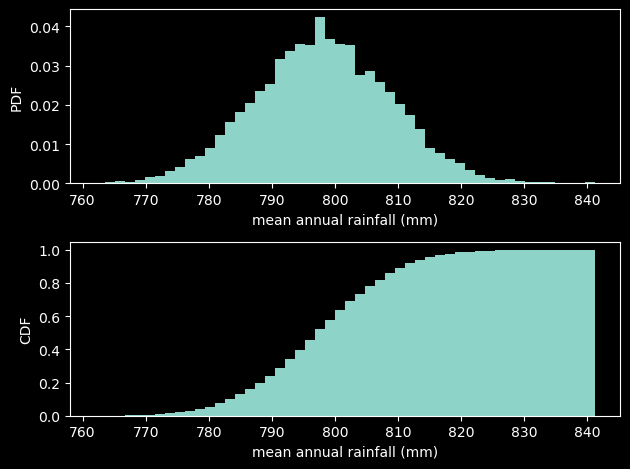

In [97]:
bs_replicates = draw_bs_reps(yearly_rain, np.mean, 10000)
plt.subplot(2,1,1)
plt.hist(bs_replicates, density=True, bins=50)
plt.xlabel('mean annual rainfall (mm)'); plt.ylabel('PDF')
plt.subplot(2,1,2)
plt.hist(bs_replicates, density=True, bins=50, cumulative=True)
plt.xlabel('mean annual rainfall (mm)'); plt.ylabel('CDF')
plt.tight_layout()
print('Empirical Mean                :', yearly_rain.mean())
print('Boostrap replicate of the mean:', bs_replicates.mean())
print('Empirical Standard Error of the Mean (SEM)   :', yearly_rain.std() / np.sqrt(len(yearly_rain)))
print('Boostrap replicates of the standard deviation:', bs_replicates.std())

Notice that the SEM we got from the known expression and the bootstrap replicates is near the same and the distribution of the bootstrap replicates of the mean is Normal.

## Confidence intervals of rainfall data
A confidence interval gives upper and lower bounds on the range of parameter values you might expect to get if we repeat our measurements.

For named distributions, you can compute them analytically or look them up, but one of the many beautiful properties of the bootstrap method is that you can take percentiles of your bootstrap replicates to get your 95% confidence interval.

In [98]:
ci = np.percentile(bs_replicates, [2.5, 97.5])
ci

array([777.06190299, 819.03807836])

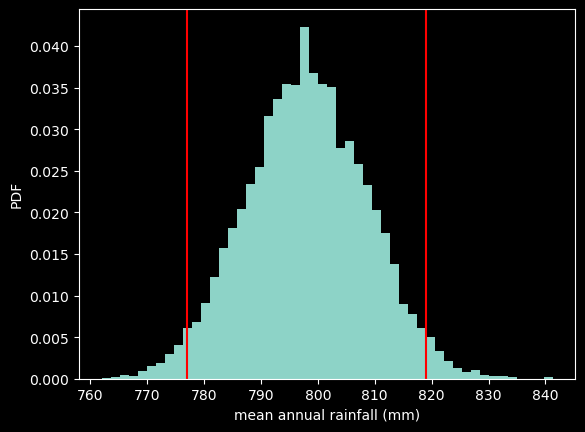

In [99]:
_ = plt.hist(bs_replicates, density=True, bins=50)
_ = plt.axvline(ci[0], color='red')
_ = plt.axvline(ci[1], color='red')
_ = plt.xlabel('mean annual rainfall (mm)')
_ = plt.ylabel('PDF')

it's simple to get confidence intervals using bootstrap!

## Bootstrap replicates of other statistics: variance
We saw in a previous exercise that the mean is Normally distributed.

This does not necessarily hold for other statistics, but no worry: as hackers, we can always take bootstrap replicates!

In this exercise, you'll generate bootstrap replicates for the variance of the annual rainfall at the Sheffield Weather Station and plot the histogram of the replicates.

Empirical Variance                : 15271.101376388733
Boostrap replicate of the variance: 15027.825117439466
Boostrap Confidence Interval      : [11838.73056883 18519.06177744]


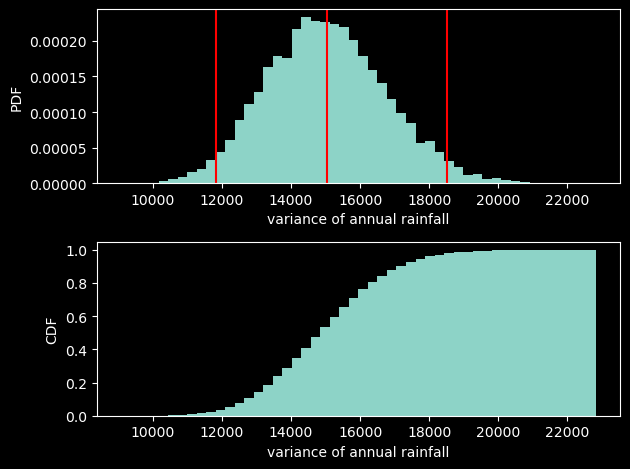

In [100]:
bs_replicates = draw_bs_reps(yearly_rain, np.var, 10000)
plt.subplot(2,1,1)
_ = plt.hist(bs_replicates, density=True, bins=50)
_ = plt.xlabel('variance of annual rainfall')
_ = plt.ylabel('PDF')
ci=np.percentile(bs_replicates, [2.5, 97.5])
_ = plt.axvline(bs_replicates.mean(), color='red')
_ = plt.axvline(ci[0], color='red')
_ = plt.axvline(ci[1], color='red')
plt.subplot(2,1,2)
_ = plt.hist(bs_replicates, density=True, bins=50, cumulative=True)
_ = plt.xlabel('variance of annual rainfall')
_ = plt.ylabel('CDF')
print("Empirical Variance                :", yearly_rain.var())
print("Boostrap replicate of the variance:", bs_replicates.mean())
print("Boostrap Confidence Interval      :", ci)
plt.tight_layout()

This is not normally distributed, as it has a longer tail to the right.

Note that you can also compute a confidence interval on the variance, or any other statistic, using np.percentile() with your bootstrap replicates.

## Confidence interval on the rate of no-hitters
Consider again the exponential distribution of the inter-no-hitter intervals for the modern era of baseball.

Generate 10,000 bootstrap replicates of the optimal parameter $\tau$.

Plot a histogram of your replicates and report a 95% confidence interval.

Empirical mean                     : 763.0358565737051 games
Boostrap replicates of the mean    : 762.4798155378487 games
Bootstrap confidence interval (95%): [662.72091633 869.11155378] games


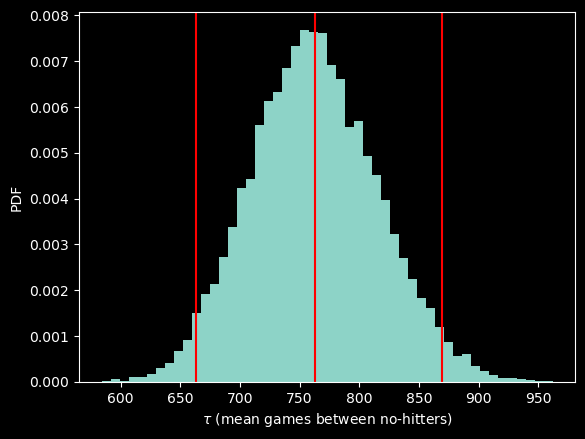

In [101]:
# Draw bootstrap replicates of the mean no-hitter time (equal to tau): bs_replicates
bs_replicates = draw_bs_reps(nohitter_interval, np.mean, 10000)
ci = np.percentile(bs_replicates, [2.5, 97.5])

print('Empirical mean                     :', nohitter_interval.mean(), 'games')
print('Boostrap replicates of the mean    :', bs_replicates.mean(), 'games')
print('Bootstrap confidence interval (95%):', ci, 'games')

_ = plt.hist(bs_replicates, bins=50, density=True)
_ = plt.xlabel(r'$\tau$ (mean games between no-hitters)')
_ = plt.ylabel('PDF')
_ = plt.axvline(bs_replicates.mean(), color='red')
_ = plt.axvline(ci[0], color='red')
_ = plt.axvline(ci[1], color='red')

This gives you an estimate of what the typical time between no-hitters is. It could be anywhere between 660 and 870 games.

## Pairs Boostrap

### Pairs bootstrap for Linear Regression function

In [102]:
def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""
    import numpy as np
    inds = np.arange(len(x))
    slopes = np.empty(size)
    intercepts = np.empty(size)
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        slopes[i], intercepts[i] = np.polyfit(x[bs_inds], y[bs_inds], deg=1)
    return slopes, intercepts

## Pairs bootstrap of literacy/fertility data
Using the function you just wrote, perform pairs bootstrap to plot a histogram describing the estimate of the slope from the illiteracy/fertility data.

Also report the 95% confidence interval of the slope.

The data is available to you in the NumPy arrays illiteracy and fertility

Slope at 95% Confidence Interval    : [0.04418379 0.05549153]
Intercept at 95% Confidence Interval: [1.75756739 2.02985696]


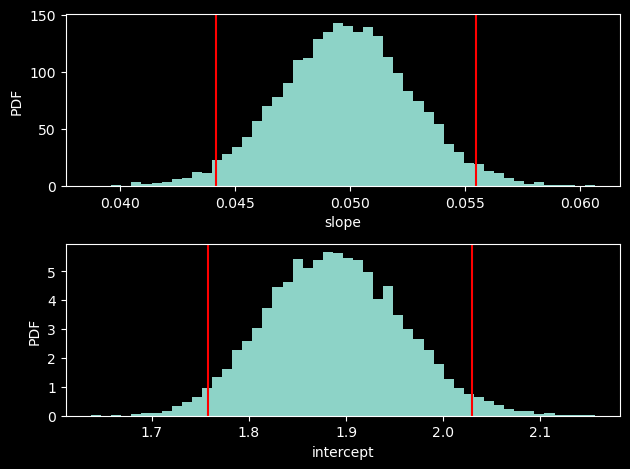

In [103]:
slopes, intercepts = draw_bs_pairs_linreg(female.illiteracy, female.fertility, 10000)

slopeCI = np.percentile(slopes, [2.5, 97.5])
interceptCI = np.percentile(intercepts, [2.5, 97.5])
print('Slope at 95% Confidence Interval    :', slopeCI)
print('Intercept at 95% Confidence Interval:', interceptCI)

plt.subplot(2,1,1)
_ = plt.hist(slopes, bins=50, density=True)
_ = plt.xlabel('slope')
_ = plt.ylabel('PDF')
_ = plt.axvline(slopeCI[0], color='red')
_ = plt.axvline(slopeCI[1], color='red')
plt.subplot(2,1,2)
_ = plt.hist(intercepts, bins=50, density=True)
_ = plt.xlabel('intercept')
_ = plt.ylabel('PDF')
_ = plt.axvline(interceptCI[0], color='red')
_ = plt.axvline(interceptCI[1], color='red')
plt.tight_layout()

## Plotting bootstrap linear regressions
A nice way to visualize the variability we might expect in a linear regression is to plot the line you would get from each bootstrap replicate of the slope and intercept.

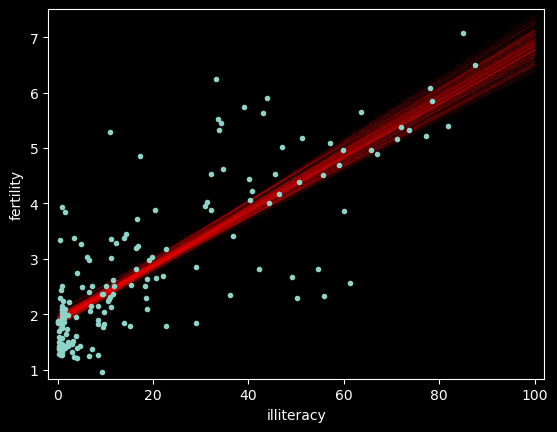

In [104]:
# Generate array of x-values for bootstrap lines: x
x = np.array([0,100])
# plot bootstrap regression lines
for i in range(100):
    plt.plot(x, slopes[i] * x + intercepts[i], linewidth=0.5, alpha=0.2, color='red')
# plot data
plt.plot(female.illiteracy, female.fertility, marker='.', linestyle='none')
plt.xlabel('illiteracy')
plt.ylabel('fertility')
plt.margins(0.02)
plt.show()

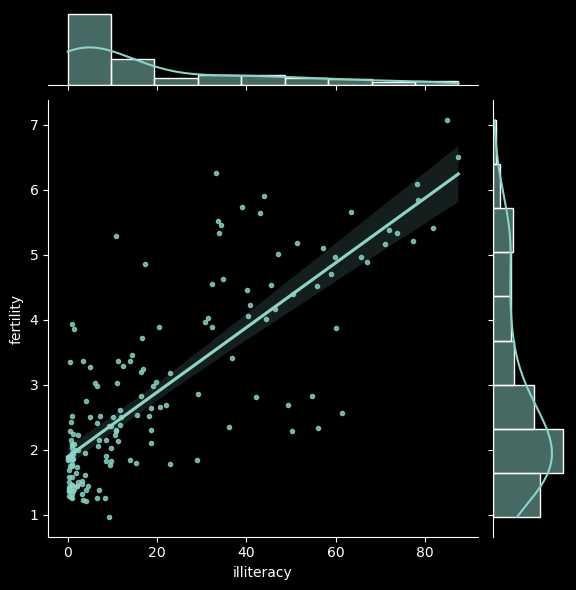

In [105]:
sns.jointplot(data=female, x='illiteracy', y='fertility', kind='reg', marker='.')

# Introduction to Hypothesis testing

## Permutation Hypothesis Testing

### Generating a permutation sample
Permutation sampling is a great way to simulate the hypothesis that two variables have identical probability distributions. 

In [106]:
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""
    data = np.concatenate((data1, data2))
    permuted_data = np.random.permutation(data)
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]
    return perm_sample_1, perm_sample_2

### Visualizing permutation sampling
To help see how permutation sampling works, let's generate permutation samples and look at them graphically.

We will use the Sheffield Weather Station data again, this time considering the monthly rainfall in June (a dry month) and November (a wet month).

We expect these might be differently distributed, so we will take permutation samples to see how their ECDFs would look if they were identically distributed.

In [107]:
rain_june = rainfall.loc[rainfall.mm==6, 'rain']
rain_november = rainfall.loc[rainfall.mm==11, 'rain']

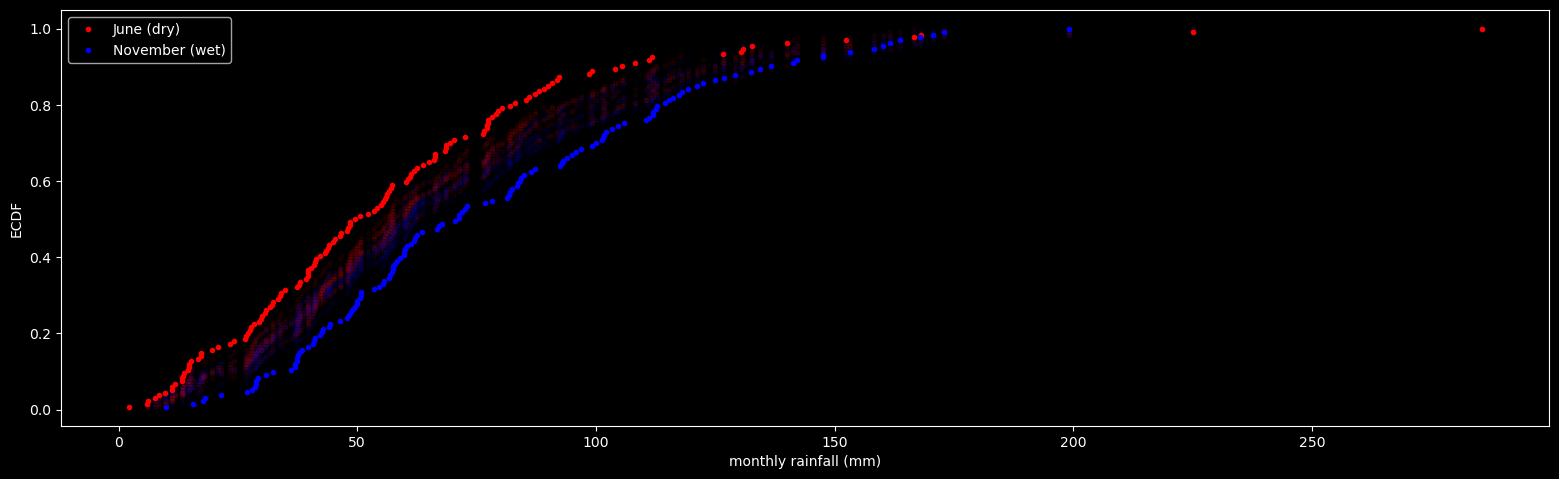

In [108]:
plt.figure(figsize=(19.2,10.8/2))
for i in range(10):
    # Generate permutation samples
    perm_sample_1, perm_sample_2 = permutation_sample(rain_june, rain_november)
    # Plot ECDFs of permutation sample
    plt.plot(*ecdf(perm_sample_1), marker='.', linestyle='none', color='red', alpha=0.05)
    plt.plot(*ecdf(perm_sample_2), marker='.', linestyle='none', color='blue', alpha=0.05)

# Create and plot ECDFs from original data
plt.plot(*ecdf(rain_june), marker='.', linestyle='none', color='red', label='June (dry)')
plt.plot(*ecdf(rain_november), marker='.', linestyle='none', color='blue', label='November (wet)')
plt.legend()
plt.xlabel('monthly rainfall (mm)')
plt.ylabel('ECDF')
plt.show()

Notice that the permutation samples ECDFs overlap and give a purple haze.

None of the ECDFs from the permutation samples overlap with the observed data, suggesting that the hypothesis is not commensurate with the data.

**June and November rainfall are not identically distributed.**

### Generating permutation replicates

In [109]:
def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""
    perm_replicates = np.empty(size)
    for i in range(size):
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)
        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)
    return perm_replicates

### Look before you leap: EDA before hypothesis testing
Kleinteich and Gorb (Sci. Rep., 4, 5225, 2014) performed an interesting experiment with South American horned frogs. They held a plate connected to a force transducer, along with a bait fly, in front of them. They then measured the impact force and adhesive force of the frog's tongue when it struck the target.

Frog A is an adult and Frog B is a juvenile. The researchers measured the impact force of 20 strikes for each frog. In the next exercise, we will test the hypothesis that the two frogs have the same distribution of impact forces. But, remember, it is important to do EDA first! Let's make a bee swarm plot for the data.

In [110]:
frogs = pd.read_csv('frog_tongue.zip', skiprows=14)
frogs.info()
frogs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 15 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   date                                                  80 non-null     object 
 1   ID                                                    80 non-null     object 
 2   trial number                                          80 non-null     int64  
 3   impact force (mN)                                     80 non-null     int64  
 4   impact time (ms)                                      80 non-null     int64  
 5   impact force / body weight                            80 non-null     float64
 6   adhesive force (mN)                                   80 non-null     int64  
 7   time frog pulls on target (ms)                        80 non-null     int64  
 8   adhesive force / body weight                          80 non-n

,date,ID,trial number,impact force (mN),impact time (ms),impact force / body weight,adhesive force (mN),time frog pulls on target (ms),adhesive force / body weight,adhesive impulse (N-s),total contact area (mm2),contact area without mucus (mm2),contact area with mucus / contact area without mucus,contact pressure (Pa),adhesive strength (Pa)
0,2013_02_26,I,3,1205,46,1.95,-785,884,1.27,-0.290,387,70,0.82,3117,-2030
1,2013_02_26,I,4,2527,44,4.08,-983,248,1.59,-0.181,101,94,0.07,24923,-9695
2,2013_03_01,I,1,1745,34,2.82,-850,211,1.37,-0.157,83,79,0.05,21020,-10239
3,2013_03_01,I,2,1556,41,2.51,-455,1025,0.74,-0.170,330,158,0.52,4718,-1381
4,2013_03_01,I,3,493,36,0.80,-974,499,1.57,-0.423,245,216,0.12,2012,-3975


In [111]:
df = frogs.loc[frogs.ID.isin(['II','IV']), ['ID','impact force (mN)']]
df.columns=['ID','impact_force']
df.ID = df.ID.map({'II':'A', 'IV':'B'})
df.impact_force /= 1000

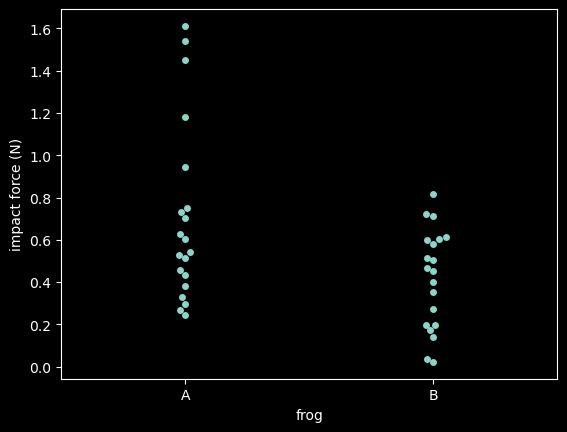

In [112]:
_ = sns.swarmplot(data=df, x='ID', y='impact_force')
_ = plt.xlabel('frog')
_ = plt.ylabel('impact force (N)')

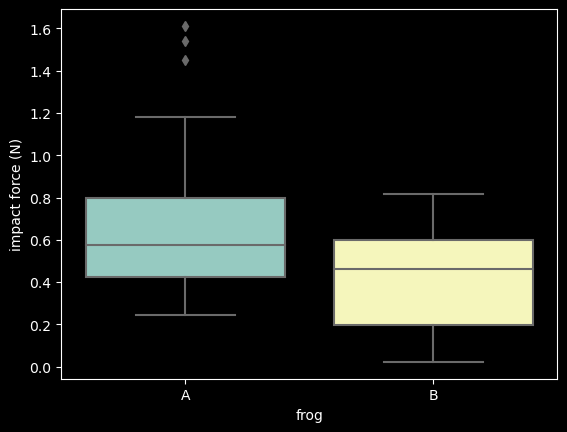

In [113]:
_ = sns.boxplot(data=df, x='ID', y='impact_force')
_ = plt.xlabel('frog')
_ = plt.ylabel('impact force (N)')

Eyeballing it, it does not look like they come from the same distribution.

Frog A, the adult, has three or four very hard strikes, and Frog B, the juvenile, has a couple weak ones.

However, it is possible that with only 20 samples it might be too difficult to tell if they have difference distributions, so we should proceed with the hypothesis test.

### Permutation test on frog data
The average strike force of Frog A was 0.71 Newtons (N), and that of Frog B was 0.42 N for a difference of 0.29 N.

In [114]:
force_a = df[df.ID=='A'].impact_force
force_b = df[df.ID=='B'].impact_force
force_a.mean(), force_b.mean(), force_a.mean()-force_b.mean()

(0.7073500000000001, 0.4191000000000001, 0.28825000000000006)

It is possible the frogs strike with the same force and this observed difference was by chance.
 
You will **compute the probability of getting at least a 0.29 N difference in mean strike force** under the **hypothesis that the distributions of strike forces for the two frogs are identical**.

We use a permutation test with a **test statistic of the difference of means** to test this hypothesis.

In [115]:
def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""
    # The difference of means of data_1, data_2: diff
    diff = data_1.mean() - data_2.mean()
    return diff

# Compute difference of mean impact force from experiment: empirical_diff_means
empirical_diff_means = diff_of_means(force_a, force_b)

# Draw 10,000 permutation replicates of the difference of mean: perm_diff_means
perm_diff_means = draw_perm_reps(force_a, force_b,
                                 diff_of_means, size=10000)

# Compute p-value: p
p = np.sum(perm_diff_means >= empirical_diff_means) / len(perm_diff_means)

# Print the result
print('p-value =', p)

p-value = 0.004


The p-value tells you that there is very small chance that you would get the difference of means observed in the experiment if frogs were exactly the same.

A p-value below 0.01 is typically said to be "statistically significant," but: warning! warning! warning! You have computed a p-value; it is a number.

I encourage you not to distill it to a yes-or-no phrase. p = 0.006 and p = 0.000000006 are both said to be "statistically significant," but they are definitely not the same!

## Bootstrap hypothesis tests
Pipeline for hypothesis testing:
* Clearly state the null hypothesis
* Define your test statistic
* Generate many sets of simulated data assuming the null hypothesis is true
* Compute the test statistic for each simulated data set
* The p-value is the fraction of your simulated data sets for which the test statistic is at least as extreme as for the real data 

### Michelson and Newcomb: speed of light pioneers
About the same time, they both measured the speed of light. Newcomb's measurements had a mean of 299,860 km/s and Michelson's 299,852 km/s. Their means differ about 8 km/s.  We only have Newcomb's mean with no data points.

**Question: Could Michelson's have gotten the data set he did if the true mean speed of light in his experiments was equal to Newcomb's?**

Null hypothesis: The true mean speed of light in Michelson's experiment was actually Newcomb's reported value.

Think the true mean speed of light in Michelson's experiments as the mean Michelson would have gotten had he done Newcomb's experiment lots of times.

**We need to simulate the situation in which the true mean speed of light in Michelson's experiments is Newcomb's value.**

To achieve this, we shift Michelson's data such that its mean now matches Newcomb's value. (Tha implies same standard deviation in shifted data)

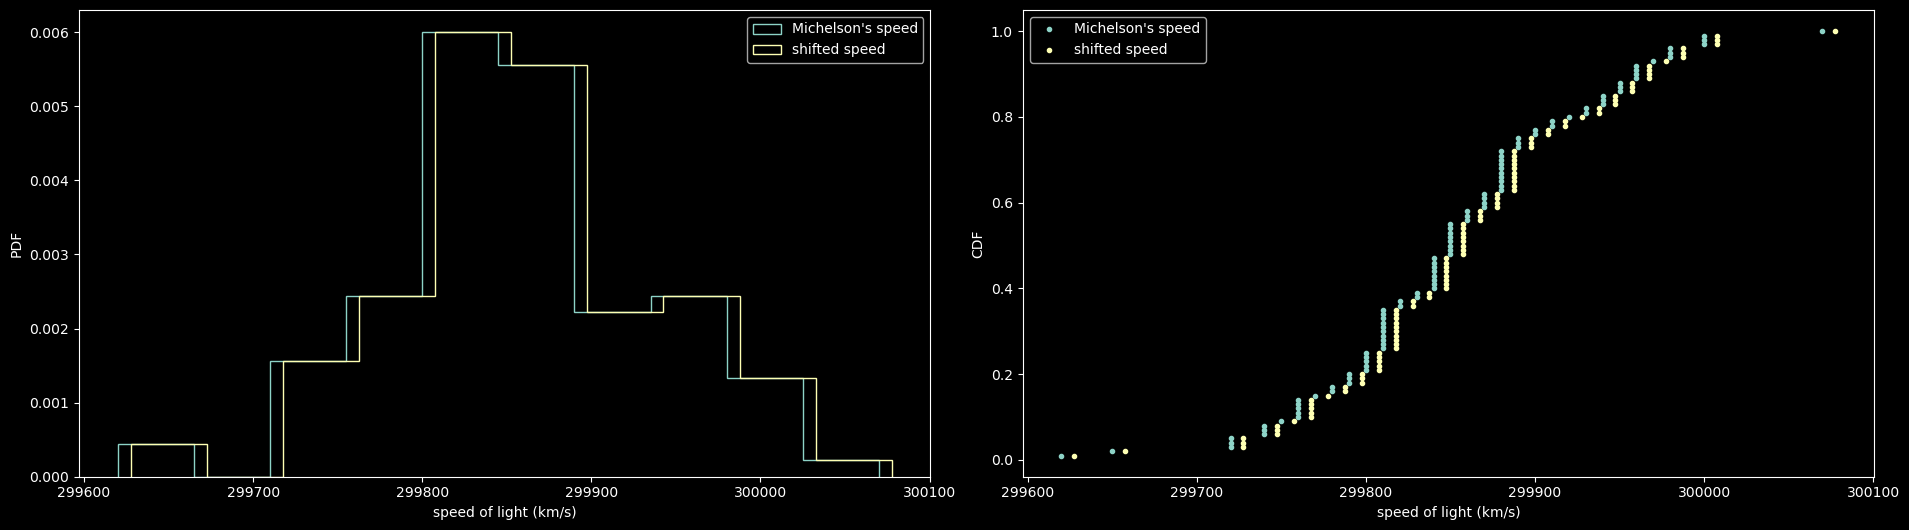

In [116]:
michelson = pd.read_csv('michelson_speed_of_light.zip')
michelson=michelson.rename(columns = {'velocity of light in air (km/s)':'speed'})
newcomb_mean = 299860
# shift Michelson's speed such that its mean now matches Newcomb's mean
michelson['shifted_speed'] = michelson.speed - michelson.speed.mean() + newcomb_mean
plt.figure(figsize=(19.2,10.8/2))
plt.subplot(1,2,1)
plt.hist(michelson.speed, density=True, histtype='step')
plt.hist(michelson.shifted_speed, density=True, histtype='step')
plt.legend(['Michelson\'s speed','shifted speed'])
plt.xlabel('speed of light (km/s)')
plt.ylabel('PDF')
plt.subplot(1,2,2)
x,y=ecdf(michelson.speed)
plt.plot(x,y, marker='.', linestyle='none')
x,y=ecdf(michelson.shifted_speed)
plt.plot(x,y, marker='.', linestyle='none')
plt.legend(['Michelson\'s speed','shifted speed'])
plt.xlabel('speed of light (km/s)')
plt.ylabel('CDF')
plt.tight_layout()

We can then use bootstrap on this shifted data to simulate data acquistion under the null hypothesis.

The test statistic is the mean of the bootstrap sample minus Newcomb's value.

In [117]:
diff_from_newcomb = lambda x: np.mean(x) - 299860

Observed mean difference

In [118]:
observed_diff = michelson.speed.mean() - newcomb_mean
observed_diff

-7.599999999976717

Boostrap shifted data to calculate the mean differences between shifted data and the Newcomb's mean

In [119]:
bs_replicates_meandiff = draw_bs_reps(michelson.shifted_speed, diff_from_newcomb, 10000)

Computing the p-value

The fraction of boostrap replicates that are less than the observed test statistic.
In this case we use less than because the mean from Michelson's experiments was less than Newcomb's value.

In [120]:
p_value = np.sum(bs_replicates_meandiff < observed_diff) / 10000
p_value

0.1662

This suggests that it's quite possible the Newcomb and Michelson did not really have fundamental differences in their measurements.

As the p-value is greater than 0.05, we should not reject the null hypothesis.

This was an one sample test.

One sample test: Compare on set of data to a single number  
Two sample test: Compare two sets of data

### A one-sample bootstrap hypothesis test
Another juvenile frog was studied, Frog C, and you want to see if Frog B and Frog C have similar impact forces. Unfortunately, you do not have Frog C's impact forces available, but you know they have a mean of 0.55 N. Because you don't have the original data, you cannot do a permutation test, and you cannot assess the hypothesis that the forces from Frog B and Frog C come from the same distribution. You will therefore test another, less restrictive hypothesis: **The mean strike force of Frog B is equal to that of Frog C.**

To set up the bootstrap hypothesis test, you will take the **mean as our test statistic**. Remember, your goal is **to calculate the probability of getting a mean impact force that is less than or equal to what was observed for Frog B if the hypothesis that the true mean of Frog B's impact forces is equal to that of Frog C is true**. You first translate all of the data of Frog B such that the mean is 0.55 N. This involves adding the mean force of Frog C and subtracting the mean force of Frog B from each measurement of Frog B.

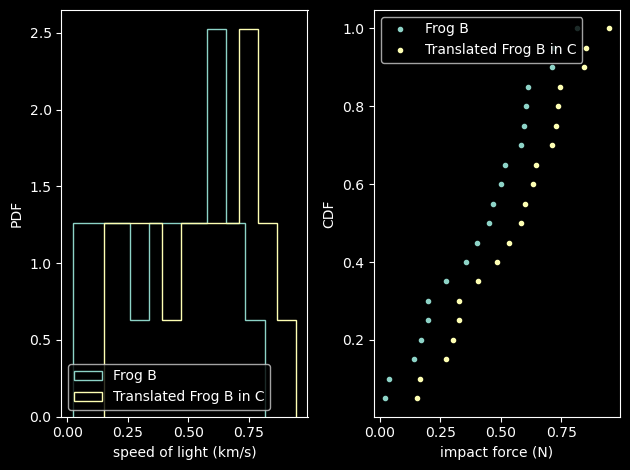

In [121]:
# Make an array of translated impact forces: translated_force_b
translated_force_b = force_b - force_b.mean() + 0.55

plt.subplot(1,2,1)
plt.hist(force_b, density=True, histtype='step')
plt.hist(translated_force_b, density=True, histtype='step')
plt.legend(['Frog B', 'Translated Frog B in C'])
plt.xlabel('speed of light (km/s)')
plt.ylabel('PDF')

plt.subplot(1,2,2)
plt.plot(*ecdf(force_b), marker='.', linestyle='none')
plt.plot(*ecdf(translated_force_b), marker='.', linestyle='none')
plt.legend(['Frog B', 'Translated Frog B in C'])
plt.xlabel('impact force (N)')
plt.ylabel('CDF')

plt.tight_layout()
plt.show()

This leaves other properties of Frog B's distribution, such as the variance, unchanged.

In [122]:
force_b.var(), translated_force_b.var()

(0.05516125263157895, 0.05516125263157896)

In [123]:
# Take bootstrap replicates of Frog B's translated impact forces: bs_replicates
bs_replicates = draw_bs_reps(translated_force_b, np.mean, 10000)
# Compute fraction of replicates that are less than the observed Frog B force: p
p = np.sum(bs_replicates <= force_b.mean()) / 10000
# Print the p-value
print('p = ', p)

p =  0.0062


The low p-value suggests that the null hypothesis that Frog B and Frog C have the same mean impact force is false.

### A two-sample bootstrap hypothesis test for difference of means
We now want to test the hypothesis that **Frog A and Frog B have the same mean impact force, but not necessarily the same distribution**, which is also impossible with a permutation test.

Empirical Mean Difference:  0.28825000000000006


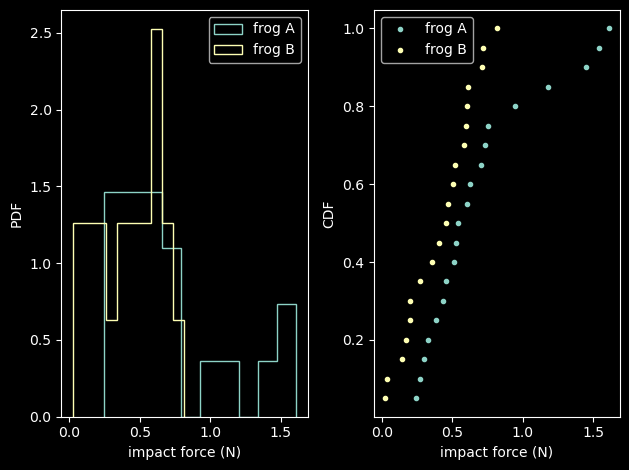

In [124]:
plt.subplot(1,2,1)
plt.hist(force_a, density=True, histtype='step', label='frog A')
plt.hist(force_b, density=True, histtype='step', label='frog B')
plt.xlabel('impact force (N)')
plt.ylabel('PDF')
plt.legend()
plt.subplot(1,2,2)
plt.plot(*ecdf(force_a), marker='.', linestyle='none', label='frog A')
plt.plot(*ecdf(force_b), marker='.', linestyle='none', label='frog B')
plt.xlabel('impact force (N)')
plt.ylabel('CDF')
plt.legend()
plt.tight_layout()
empirical_diff_means = diff_of_means(force_a, force_b)
print('Empirical Mean Difference: ', empirical_diff_means)

To do the two-sample bootstrap test, we shift both arrays to have the same mean, since we are simulating the hypothesis that their means are, in fact, equal.

In [125]:
# Compute mean of all forces: mean_force
mean_force = np.concatenate((force_a, force_b)).mean()
mean_force

0.563225

In [126]:
# Generate shifted arrays
force_a_shifted = force_a - np.mean(force_a) + mean_force
force_b_shifted = force_b - np.mean(force_b) + mean_force

We then draw bootstrap samples out of the shifted arrays and compute the difference in means.
 
This constitutes a bootstrap replicate, and we generate many of them.

The p-value is the fraction of replicates with a difference in means greater than or equal to what was observed.

In [127]:
# Compute 10,000 bootstrap replicates from shifted arrays
bs_replicates_a = draw_bs_reps(force_a_shifted, np.mean, 10000)
bs_replicates_b = draw_bs_reps(force_b_shifted, np.mean, 10000)
# Get replicates of difference of means: bs_replicates
bs_replicates = bs_replicates_a - bs_replicates_b
# Compute and print p-value: p
p = np.sum(bs_replicates >= empirical_diff_means) / len(bs_replicates)
print('p-value =', p)

p-value = 0.0049


You got a similar result as when you did the permutation test.

Nonetheless, remember that it is important to carefully think about what question you want to ask.

Are you only interested in the mean impact force, or in the distribution of impact forces?

# Hypothesis test examples

## A/B Testing

### The vote for the Civil Rights Act in 1964
The Civil Rights Act of 1964 was one of the most important pieces of legislation ever passed in the USA. Excluding "present" and "abstain" votes, 153 House Democrats and 136 Republicans voted yea. However, 91 Democrats and 35 Republicans voted nay.

Question: Did party affiliation make a difference in the vote? **i.e. do votes belong to different distributions?**

To answer this question, you will evaluate the hypothesis that the party of a House member has no bearing on his or her vote.  You will use **the fraction of Democrats voting in favor as your test statistic** and evaluate the **probability of observing a fraction of Democrats voting in favor at least as small as the observed fraction of 153/244**. (That's right, at least as small as. In 1964, it was the Democrats who were less progressive on civil rights issues.)

Once the observed Dems fraction is smaller than the observed Reps fraction, it's expected that, under the null hypothesis that permutation would NOT increase Dems fraction, a more extreme test statistic value would be if the permutation yields a fraction smaller or equal than the observed Dems fraction.

To do this, permute the party labels of the House voters and then arbitrarily divide them into "Democrats" and "Republicans" and compute the fraction of Democrats voting yea.

In [132]:
"Dems fraction", 153/(153+91), "Reps fraction", 136/(136+35)

('Dems fraction', 0.6270491803278688, 'Reps fraction', 0.7953216374269005)

In [140]:
# Construct arrays of data: dems, reps
dems = np.array([True] * 153 + [False] * 91)
reps = np.array([True] * 136 + [False] * 35)

def frac_yea_dems(dems, reps):
    """Compute fraction of Democrat yea votes."""
    frac = np.mean(dems)
    return frac

# Acquire permutation samples: perm_replicates
np.random.seed(0)
perm_replicates = draw_perm_reps(dems, reps, frac_yea_dems, size=10000)

# Compute and print p-value: p
p = np.mean(perm_replicates <= 153/244)
print('p-value =', p)

p-value = 0.0003


This small p-value suggests that party identity had a lot to do with the voting. Importantly, the South had a higher fraction of Democrat representatives, and consequently also a more racist bias.

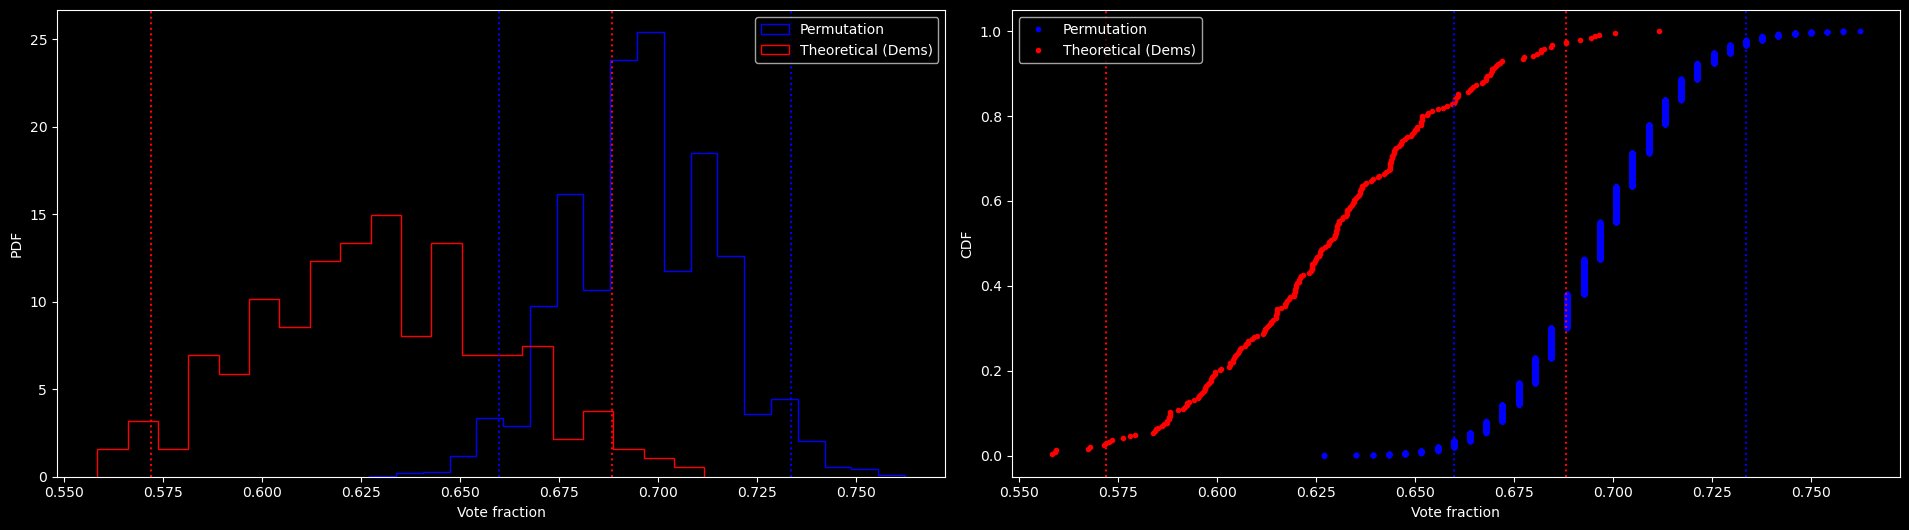

In [146]:
theoretical = np.random.normal(dems.mean(), dems.std()/np.sqrt(len(dems)), size=len(dems))

plt.figure(figsize=(19.2,10.8/2))
plt.subplot(1,2,1)
plt.hist(perm_replicates, density=True, histtype='step', bins=20, color='blue', label='Permutation')
plt.hist(theoretical, density=True, histtype='step', bins=20, color='red', label='Theoretical (Dems)')
plt.xlabel('Vote fraction')
plt.ylabel('PDF')
plt.legend()

ci=np.percentile(perm_replicates, [2.5, 97.5])
plt.axvline(ci[0], color='blue', linestyle='dotted')
plt.axvline(ci[1], color='blue', linestyle='dotted')
ci=np.percentile(theoretical, [2.5, 97.5])
plt.axvline(ci[0], color='red', linestyle='dotted')
plt.axvline(ci[1], color='red', linestyle='dotted')

plt.subplot(1,2,2)
plt.plot(*ecdf(perm_replicates), marker='.', linestyle='none', color='blue', label='Permutation')
plt.plot(*ecdf(theoretical), marker='.', linestyle='none', color='red', label='Theoretical (Dems)')
plt.xlabel('Vote fraction')
plt.ylabel('CDF')
plt.legend()
ci=np.percentile(perm_replicates, [2.5, 97.5])
plt.axvline(ci[0], color='blue', linestyle='dotted')
plt.axvline(ci[1], color='blue', linestyle='dotted')
ci=np.percentile(theoretical, [2.5, 97.5])
plt.axvline(ci[0], color='red', linestyle='dotted')
plt.axvline(ci[1], color='red', linestyle='dotted')

plt.tight_layout()
plt.show()

### A time-on-website analog: No-hitter interval between MLB's eras
It turns out that you already did a hypothesis test analogous to an A/B test where you are interested in how much time is spent on the website before and after an ad campaign. The frog tongue force (a continuous quantity like time on the website) is an analog. "Before" = Frog A and "after" = Frog B. Let's practice this again with something that actually is a before/after scenario.

We return to the no-hitter data set. In 1920, Major League Baseball implemented important rule changes that ended the so-called dead ball era. Importantly, the pitcher was no longer allowed to spit on or scuff the ball, an activity that greatly favors pitchers. In this problem you will perform an A/B test to determine if these rule changes resulted in a slower rate of no-hitters (i.e., longer average time between no-hitters) using the difference in mean inter-no-hitter time as your test statistic. The inter-no-hitter times for the respective eras are stored in the arrays nht_dead and nht_live, where "nht" is meant to stand for "no-hitter time."

In [161]:
# nht_dead = nohitter.loc[:'1919','game_number'].diff().fillna(0) - 1 #dropna()?
nht_dead = nohitter.loc[:'1919','game_number'].diff().dropna() - 1
nht_live = nohitter.loc['1919-09-10':,'game_number'].diff().dropna() - 1
nht_dead, nht_live

(date
 1880-06-12     894.0
 1880-06-17      10.0
 1880-08-19     130.0
 1880-08-20       1.0
 1882-09-11     934.0
                ...  
 1917-05-06       2.0
 1917-06-23     308.0
 1918-06-03    1114.0
 1919-05-11     813.0
 1919-09-10     887.0
 Name: game_number, Length: 90, dtype: float64,
 date
 1920-07-01     645.0
 1922-04-30    2088.0
 1922-05-07      42.0
 1923-09-04    2090.0
 1923-09-07      11.0
                ...  
 2015-07-25     419.0
 2015-08-12     239.0
 2015-08-21     119.0
 2015-08-30     129.0
 2015-10-03     467.0
 Name: game_number, Length: 203, dtype: float64)

In [162]:
# Compute the observed difference in mean inter-no-hitter times: nht_diff_obs
nht_diff_obs = diff_of_means(nht_dead, nht_live)
nht_diff_obs

-339.67110016420355

The observed dead ball era mean time is smaller the observed live ball era mean time, therefore, the mean difference is negative and it's expected that, under the null hypothesis that permutation would NOT affect the mean difference, a more extreme test statistic value would be if the permutation yields mean difference smaller or equal than the observed difference in mean inter-no-hitter times.

In [163]:
# Acquire 10,000 permutation replicates of difference in mean no-hitter time: perm_replicates
perm_replicates = draw_perm_reps(nht_dead, nht_live, diff_of_means, size=10000)

Comparing the ECDF of the dead and live eras

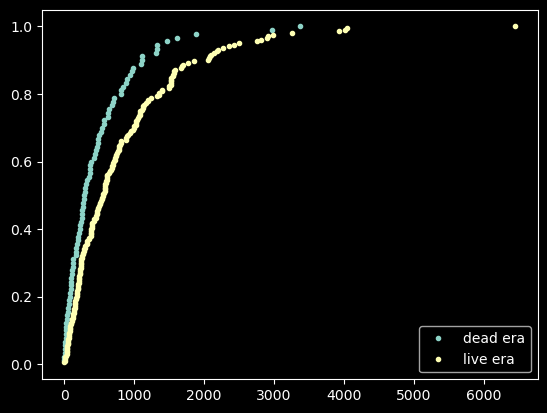

In [164]:
plt.plot(*ecdf(nht_dead), marker='.', linestyle='none')
plt.plot(*ecdf(nht_live), marker='.', linestyle='none')
plt.legend(['dead era', 'live era'])
plt.show()

You see by eye that the null hypothesis that the distributions are the same is almost certainly not true.

In [165]:
np.mean(perm_replicates <= nht_diff_obs)

0.0

Your p-value is smaller the 0.05, which means that only a small fraction out of your 10,000 replicates had a result as extreme as the actual difference between the dead ball and live ball eras. This suggests strong statistical significance to reject the null hypothesis of no mean difference. Watch out, though, you could very well have gotten zero replicates that were as extreme as the observed value. This just means that the p-value is quite small, almost certainly smaller than 0.001.

## Test of correlation

### Hypothesis test on Pearson correlation
The observed correlation between female illiteracy and fertility may just be by chance; the fertility of a given country may actually be totally independent of its illiteracy. You will test this hypothesis.

To do so, permute the illiteracy values but leave the fertility values fixed. This simulates the hypothesis that they are totally independent of each other.

For each permutation, compute the Pearson correlation coefficient and assess how many of your permutation replicates have a Pearson correlation coefficient greater than the observed one.

In [183]:
# Compute observed correlation: r_obs
r_obs = np.corrcoef(female.illiteracy, female.fertility)[0,1]
r_obs

0.8041324026815344

In [191]:
# Initialize permutation replicates: perm_replicates
perm_replicates = np.empty(10000)
# Draw replicates
for i in range(len(perm_replicates)):
    # Permute illiteracy measurments: illiteracy_permuted
    illiteracy_permuted = np.random.permutation(female.illiteracy)
    # Compute Pearson correlation
    perm_replicates[i] = np.corrcoef(illiteracy_permuted, female.fertility)[0,1]
# Compute p-value: p
np.mean(perm_replicates > r_obs)

0.0

You got a p-value of zero or close to. In hacker statistics, this means that your p-value is very low, since you never got a single replicate in the 10,000 you took that had a Pearson correlation greater than the observed one. You could try increasing the number of replicates you take to continue to move the upper bound on your p-value lower and lower.

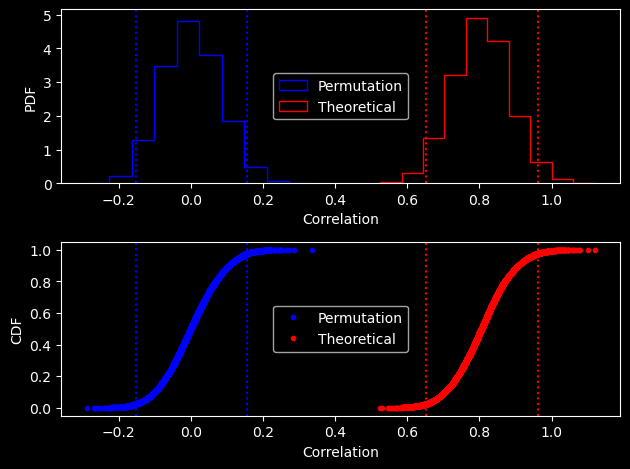

In [190]:
theoretical = np.random.normal(r_obs, perm_replicates.std(), 10000)

plt.subplot(2,1,1)
plt.hist(perm_replicates, density=True, color='blue', histtype='step', label='Permutation')
plt.hist(theoretical, density=True, color='red', histtype='step', label='Theoretical')
plt.xlabel('Correlation')
plt.ylabel('PDF')
plt.legend(loc='center')

ci=np.percentile(perm_replicates, [2.5, 97.5])
plt.axvline(ci[0], color='blue', linestyle='dotted')
plt.axvline(ci[1], color='blue', linestyle='dotted')
ci=np.percentile(theoretical, [2.5, 97.5])
plt.axvline(ci[0], color='red', linestyle='dotted')
plt.axvline(ci[1], color='red', linestyle='dotted')

plt.subplot(2,1,2)
plt.plot(*ecdf(perm_replicates), marker='.', linestyle='none', color='blue', label='Permutation')
plt.plot(*ecdf(theoretical), marker='.', linestyle='none', color='red', label='Theoretical')
plt.xlabel('Correlation')
plt.ylabel('CDF')
plt.legend(loc='center')

ci=np.percentile(perm_replicates, [2.5, 97.5])
plt.axvline(ci[0], color='blue', linestyle='dotted')
plt.axvline(ci[1], color='blue', linestyle='dotted')
ci=np.percentile(theoretical, [2.5, 97.5])
plt.axvline(ci[0], color='red', linestyle='dotted')
plt.axvline(ci[1], color='red', linestyle='dotted')

plt.tight_layout()
plt.show()

## Do neonicotinoid insecticides have unintended consequences?
As a final exercise in hypothesis testing before we put everything together in our case study in the next chapter, you will investigate the effects of neonicotinoid insecticides on bee reproduction. These insecticides are very widely used in the United States to combat aphids and other pests that damage plants.

In a recent study, Straub, et al. (Proc. Roy. Soc. B, 2016) investigated the effects of neonicotinoids on the sperm of pollinating bees. In this and the next exercise, you will study how the pesticide treatment affected the count of live sperm per half milliliter of semen.

In [201]:
# Count of live sperm per half milliliter of semen of control and treated bees
bees = pd.read_csv('bee_sperm.zip', skiprows=3)
control = bees.loc[bees.Treatment=='Control', 'Alive Sperm Millions'] / .5
treated = bees.loc[bees.Treatment=='Pesticide', 'Alive Sperm Millions'] / .5

First, we will do EDA, as usual. Plot ECDFs of the alive sperm count for untreated bees and bees treated with pesticide.

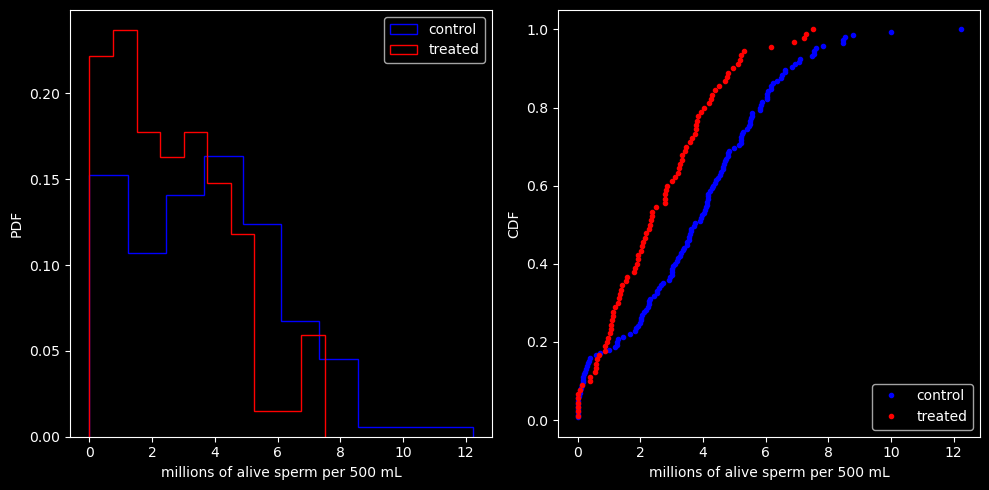

In [202]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(control, density=True, color='blue', histtype='step', label='control')
plt.hist(treated, density=True, color='red', histtype='step', label='treated')
plt.xlabel('millions of alive sperm per 500 mL')
plt.ylabel('PDF')
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.plot(*ecdf(control), marker='.', linestyle='none', color='blue', label='control')
plt.plot(*ecdf(treated), marker='.', linestyle='none', color='red', label='treated')
plt.ylabel('CDF')
plt.xlabel('millions of alive sperm per 500 mL')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

The ECDFs show a pretty clear difference between the treatment and control: **Treated bees have fewer alive sperm.**

Let's now do a hypothesis test in the next exercise.

### Bootstrap hypothesis test on bee sperm counts
Now, you will test the following hypothesis:

> On average, bees treated with neonicotinoid insecticide have the same number of active sperm per milliliter of semen than do untreated bees. You will use the difference of means as your test statistic.

In [60]:
# Compute the difference in mean sperm count: diff_means
diff_means = diff_of_means(control, treated)
diff_means

1.1460587295019158

In [61]:
# Compute mean of pooled data: mean_count
mean_count = np.mean(np.concatenate((control, treated)))
mean_count

3.3066380425531916

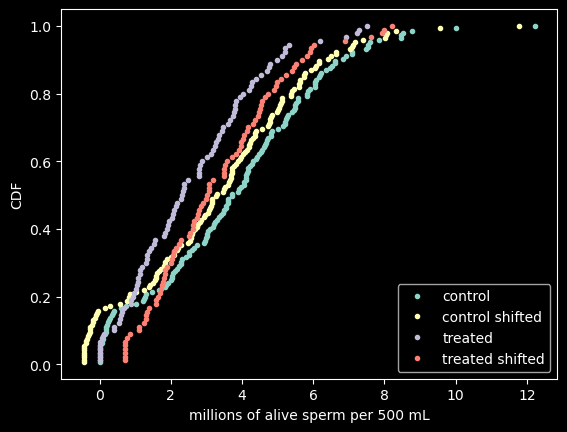

In [203]:
# Generate mean shifted data sets
control_shifted = control - np.mean(control) + mean_count
treated_shifted = treated - np.mean(treated) + mean_count
plt.plot(*ecdf(control), marker='.', linestyle='none', label='control')
plt.plot(*ecdf(control_shifted), marker='.', linestyle='none', label='control shifted')
plt.plot(*ecdf(treated), marker='.', linestyle='none', label='treated')
plt.plot(*ecdf(treated_shifted), marker='.', linestyle='none', label='treated shifted')
plt.ylabel('CDF')
plt.xlabel('millions of alive sperm per 500 mL')
plt.legend(loc='lower right')
plt.show()

In [209]:
# Generate bootstrap replicates
bs_reps_control = draw_bs_reps(control_shifted, np.mean, size=100000)
bs_reps_treated = draw_bs_reps(treated_shifted, np.mean, size=100000)

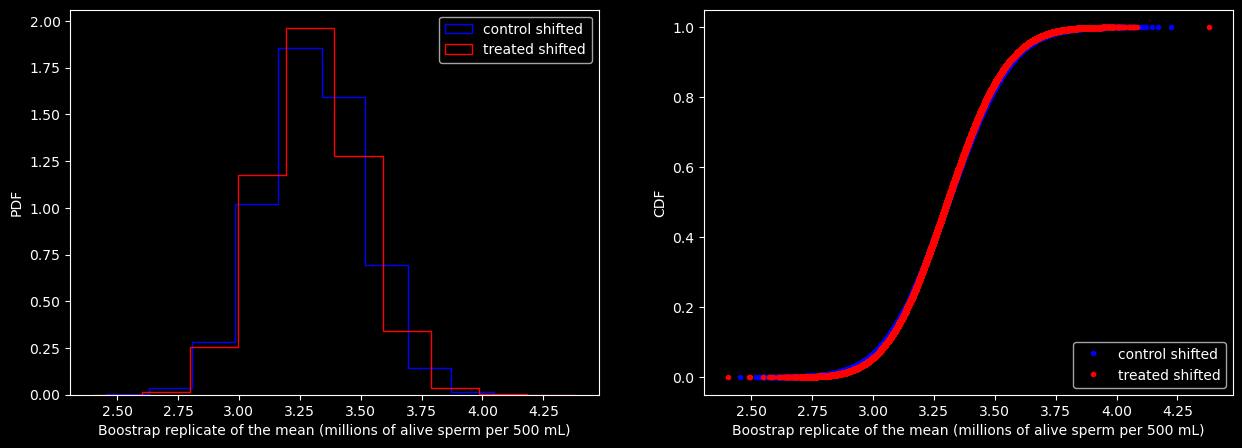

In [243]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(bs_reps_control, density=True, color='blue', histtype='step', label='control shifted')
plt.hist(bs_reps_treated, density=True, color='red', histtype='step', label='treated shifted')
plt.ylabel('PDF')
plt.xlabel('Boostrap replicate of the mean (millions of alive sperm per 500 mL)')
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.plot(*ecdf(bs_reps_control), marker='.', color='blue', linestyle='none', label='control shifted')
plt.plot(*ecdf(bs_reps_treated), marker='.', color='red', linestyle='none', label='treated shifted')
plt.ylabel('CDF')
plt.xlabel('Boostrap replicate of the mean (millions of alive sperm per 500 mL)')
plt.legend(loc='lower right')
plt.show()

In [65]:
# Get replicates of difference of means: bs_replicates
bs_replicates = bs_reps_control - bs_reps_treated
# Compute and print p-value: p
np.mean(bs_replicates >= diff_means)

0.0002

The p-value is small, most likely less than 0.0001, since you never saw a bootstrap replicated with a difference of means at least as extreme as what was observed. With the calculation with 10 million replicates, p-value was 2e-05.

# Putting it all together: a case study
Investigation of G. scandens beak depth
* EDA of beak depths in 1975 and 2012
* Parameter estimates of mean beak depth
* Hypothesis test: did the beaks get deeper?

In [244]:
df = pd.read_csv('finch_beaks_1975.zip')
df = df.rename(columns = {'Beak depth, mm':'beak_depth', 'Beak length, mm':'beak_length'})
df['year'] = 1975
df = df.loc[df.species=='scandens', ['beak_depth', 'beak_length', 'year']]

df2 = pd.read_csv('finch_beaks_2012.zip')
df2 = df2.rename(columns = {'bdepth':'beak_depth', 'blength':'beak_length'})
df2['year'] = 2012
df2 = df2.loc[df2.species=='scandens', ['beak_depth','beak_length', 'year']]

df = pd.concat((df, df2), ignore_index=True)
df

,beak_depth,beak_length,year
0,8.4,13.9,1975
1,8.8,14.0,1975
2,8.4,12.9,1975
3,8.0,13.5,1975
4,7.9,12.9,1975
...,...,...,...
209,9.3,14.2,2012
210,9.8,13.0,2012
211,8.9,14.6,2012
212,9.8,13.1,2012


## EDA of beak depths of Darwin's finches
For your first foray into the Darwin finch data, you will study how the beak depth (the distance, top to bottom, of a closed beak) of the finch species Geospiza scandens has changed over time. The Grants have noticed some changes of beak geometry depending on the types of seeds available on the island, and they also noticed that there was some interbreeding with another major species on Daphne Major, Geospiza fortis. These effects can lead to changes in the species over time.

In the next few problems, you will look at the beak depth of G. scandens on Daphne Major in 1975 and in 2012. To start with, let's plot all of the beak depth measurements in 1975 and 2012 in a bee swarm plot.

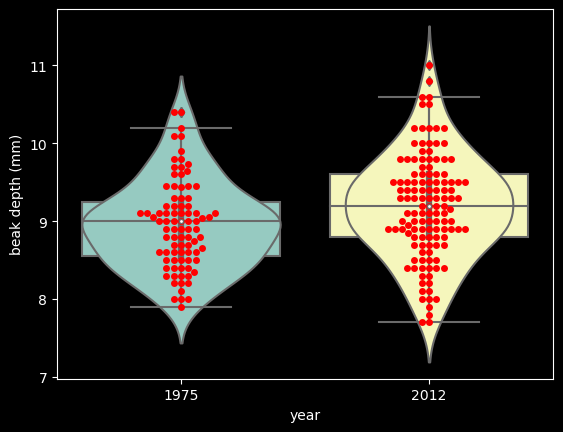

In [255]:
# Create bee swarm plot
sns.swarmplot(data=df, x='year', y='beak_depth', color='red')
sns.violinplot(data=df, x='year', y='beak_depth')
sns.boxplot(data=df, x='year', y='beak_depth')
plt.xlabel('year')
plt.ylabel('beak depth (mm)')
plt.show()

It is kind of hard to see if there is a clear difference between the 1975 and 2012 data set. Eyeballing it, it appears as though the mean of the 2012 data set might be slightly higher, and it might have a bigger variance.

## ECDFs of beak depths
While bee swarm plots are useful, we found that ECDFs are often even better when doing EDA. Plot the ECDFs for the 1975 and 2012 beak depth measurements on the same plot.

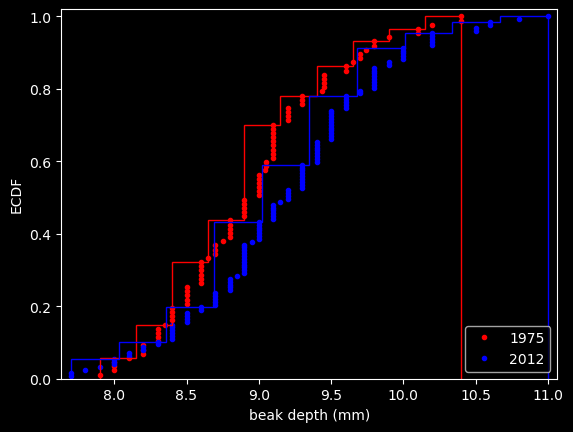

In [265]:
# Plot the ECDFs
bd_1975 = df.beak_depth[df.year==1975].values
bd_2012 = df.beak_depth[df.year==2012].values
plt.plot(*ecdf(bd_1975), marker='.', linestyle='none', label='1975', color='red')
plt.plot(*ecdf(bd_2012), marker='.', linestyle='none', label='2012', color='blue')
plt.hist(bd_1975, density=True, cumulative=True, histtype='step', color='red')
plt.hist(bd_2012, density=True, cumulative=True, histtype='step', color='blue')
plt.margins(0.02)
plt.xlabel('beak depth (mm)')
plt.ylabel('ECDF')
plt.legend(loc='lower right')
plt.show()

The differences are much clearer in the ECDF. The mean is larger in the 2012 data, and the variance does appear larger as well.

## Parameter estimates of beak depths
Estimate the difference of the mean beak depth of the G. scandens samples from 1975 and 2012 and report a 95% confidence interval.

In [266]:
# Compute the difference of the sample means: mean_diff
mean_diff = diff_of_means(bd_2012, bd_1975)

# Get bootstrap replicates of means
bs_replicates_1975 = draw_bs_reps(bd_1975, np.mean, 10000)
bs_replicates_2012 = draw_bs_reps(bd_2012, np.mean, 10000)

# Compute samples of difference of means: bs_diff_replicates
bs_diff_replicates = bs_replicates_2012 - bs_replicates_1975

# Compute 95% confidence interval: conf_int
conf_int = np.percentile(bs_diff_replicates, [2.5, 97.5])

# Print the results
print('difference of means     =', mean_diff, 'mm')
print('95% confidence interval =', conf_int, 'mm')

difference of means     = 0.22622047244094645 mm
95% confidence interval = [0.05736707 0.39259338] mm


## Hypothesis test: Are beaks deeper in 2012?
Your plot of the ECDF and determination of the confidence interval make it pretty clear that the beaks of G. scandens on Daphne Major have gotten deeper. But is it possible that this effect is just due to random chance? In other words, what is the probability that we would get the observed difference in mean beak depth if the means were the same?

Be careful! The hypothesis we are testing is not that the beak depths come from the same distribution. For that we could use a permutation test. The hypothesis is that the means are equal. To perform this hypothesis test, we need to shift the two data sets so that they have the same mean and then use bootstrap sampling to compute the difference of means.

In [267]:
# Compute mean of combined data set: combined_mean
combined_mean = np.mean(np.concatenate((bd_1975, bd_2012)))
combined_mean

9.094252336448596

In [268]:
# Shift the samples
bd_1975_shifted = bd_1975 - np.mean(bd_1975) + combined_mean
bd_2012_shifted = bd_2012 - np.mean(bd_2012) + combined_mean

# Get bootstrap replicates of shifted data sets
bs_replicates_1975 = draw_bs_reps(bd_1975_shifted, np.mean, 10000)
bs_replicates_2012 = draw_bs_reps(bd_2012_shifted, np.mean, 10000)

# Compute replicates of difference of means: bs_diff_replicates
bs_diff_replicates = bs_replicates_2012 - bs_replicates_1975

# Compute the p-value
np.sum(bs_diff_replicates >= mean_diff) / len(bs_diff_replicates)

0.0035

We get a smaller p-value, which suggests that there is a statistically significant difference.

**But remember**: it is very important to know how different they are! In the previous exercise, you got a difference of 0.2 mm between the means. You should combine this with the statistical significance. Changing by 0.2 mm in 37 years is substantial by evolutionary standards. If it kept changing at that rate, the beak depth would double in only 400 years.

## EDA of beak length and depth
Make scatter plots of beak depth (y-axis) versus beak length (x-axis) for the 1975 and 2012 specimens.

In [273]:
bl_1975 = df.beak_length[df.year==1975].values
bl_2012 = df.beak_length[df.year==2012].values

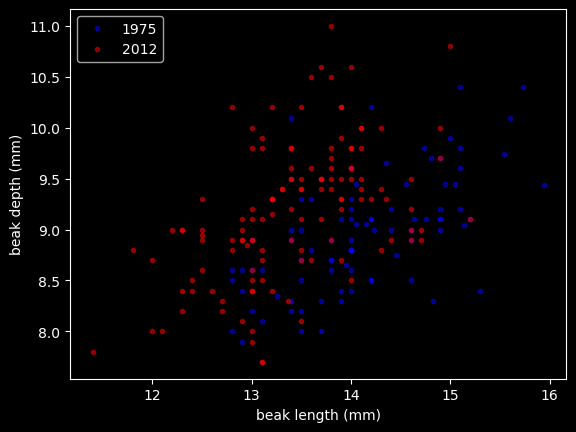

In [274]:
plt.plot(bl_1975, bd_1975, marker='.', linestyle='none', color='blue', alpha=0.5, label='1975')
plt.plot(bl_2012, bd_2012, marker='.', linestyle='none', color='red', alpha=0.5, label='2012')
plt.xlabel('beak length (mm)')
plt.ylabel('beak depth (mm)')
plt.legend(loc='upper left')
plt.show()

In looking at the plot, we see that beaks got deeper (the red points are higher up in the y-direction), but not really longer. If anything, they got a bit shorter, since the red dots are to the left of the blue dots. So, it does not look like the beaks kept the same shape; they became shorter and deeper.

## Linear regressions
Perform a linear regression for both the 1975 and 2012 data. Then, perform pairs bootstrap estimates for the regression parameters. Report 95% confidence intervals on the slope and intercept of the regression line.

In [275]:
# Compute the linear regressions
slope_1975, intercept_1975 = np.polyfit(bl_1975, bd_1975, deg=1)
slope_2012, intercept_2012 = np.polyfit(bl_2012, bd_2012, deg=1)

# Perform pairs bootstrap for the linear regressions
bs_slope_reps_1975, bs_intercept_reps_1975 = \
        draw_bs_pairs_linreg(bl_1975, bd_1975, size=1000)
bs_slope_reps_2012, bs_intercept_reps_2012 = \
        draw_bs_pairs_linreg(bl_2012, bd_2012, size=1000)

# Compute confidence intervals of slopes
slope_conf_int_1975 = np.percentile(bs_slope_reps_1975, [2.5, 97.5])
slope_conf_int_2012 = np.percentile(bs_slope_reps_2012, [2.5, 97.5])
intercept_conf_int_1975 = np.percentile(bs_intercept_reps_1975, [2.5, 97.5])
intercept_conf_int_2012 = np.percentile(bs_intercept_reps_2012, [2.5, 97.5])

# Print the results
print('1975: slope =', slope_1975, 'conf int =', slope_conf_int_1975)
print('1975: intercept =', intercept_1975, 'conf int =', intercept_conf_int_1975)
print('2012: slope =', slope_2012, 'conf int =', slope_conf_int_2012)
print('2012: intercept =', intercept_2012, 'conf int =', intercept_conf_int_2012)

1975: slope = 0.4652051691605937 conf int = [0.33141383 0.59169797]
1975: intercept = 2.3908752365842263 conf int = [0.63489799 4.28382325]
2012: slope = 0.462630358835313 conf int = [0.33872354 0.59709967]
2012: intercept = 2.9772474982360198 conf int = [1.18035994 4.64656748]


It looks like they have the same slope, but different intercepts.

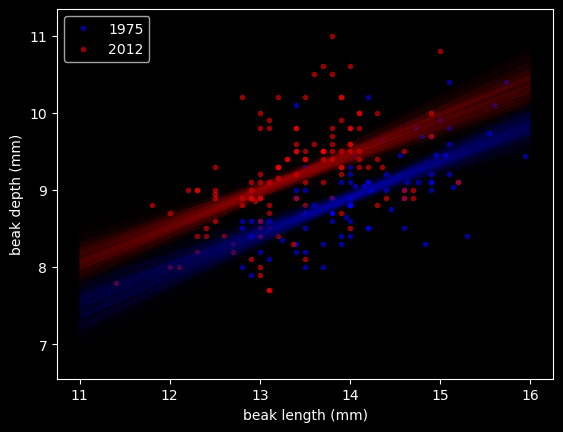

In [288]:
plt.plot(bl_1975, bd_1975, marker='.', linestyle='none', color='blue', alpha=0.5, label='1975')
plt.plot(bl_2012, bd_2012, marker='.', linestyle='none', color='red', alpha=0.5, label='2012')
plt.xlabel('beak length (mm)')
plt.ylabel('beak depth (mm)')
plt.legend(loc='upper left')

# Generate x-values for bootstrap lines: x
x = np.array([11, 16])

# Plot the bootstrap lines

for i in range(len(bs_slope_reps_1975)):
    plt.plot(x, bs_slope_reps_1975[i] * x + bs_intercept_reps_1975[i],
             linewidth=0.5, alpha=0.02, color='blue')
    plt.plot(x, bs_slope_reps_2012[i] * x + bs_intercept_reps_2012[i],
             linewidth=0.5, alpha=0.02, color='red')

# Draw the plot again
plt.show()

/home/mauricio/miniconda3/envs/dev/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


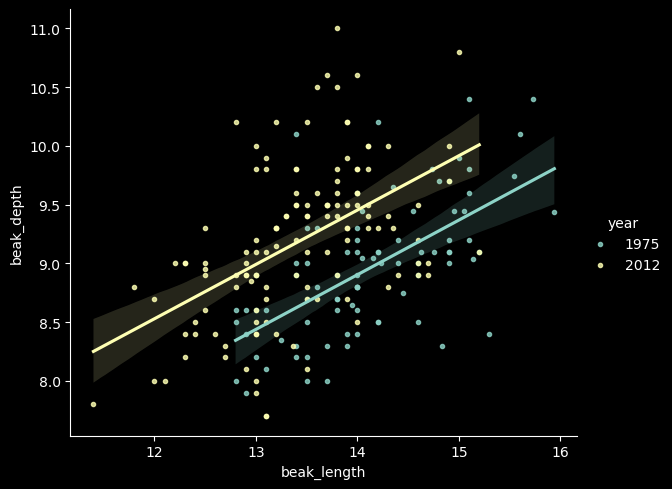

In [314]:
sns.lmplot(data=df, x='beak_length', y='beak_depth', hue='year', aspect=1.2, markers='.')
plt.show()

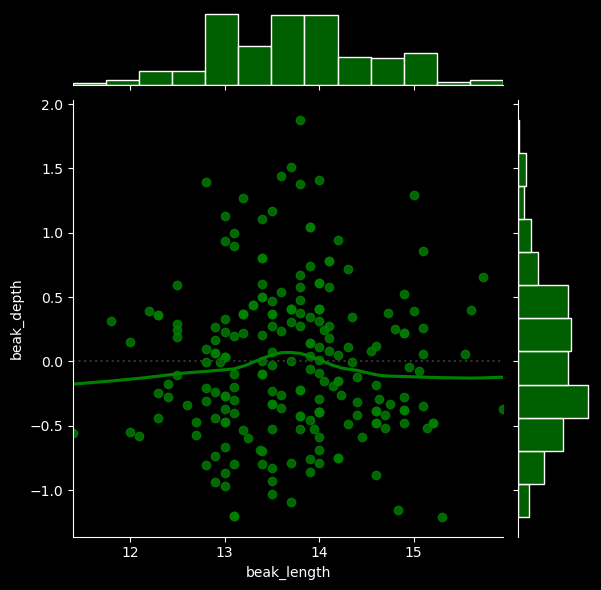

In [304]:
sns.jointplot(data=df, x='beak_length', y='beak_depth', kind='resid', color='green', lowess=True)
plt.show()

/home/mauricio/miniconda3/envs/dev/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


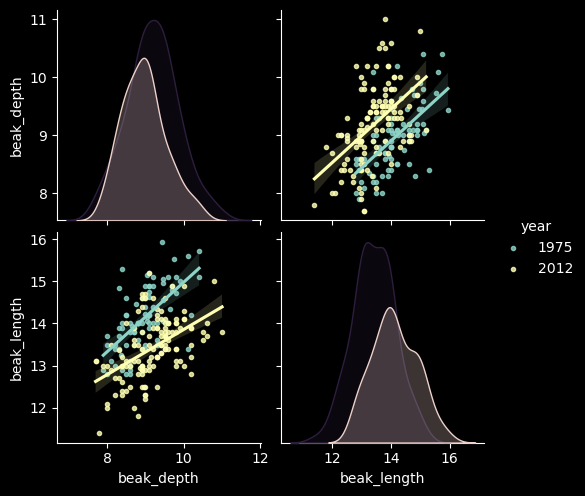

In [313]:
sns.pairplot(df, hue='year', kind='reg', diag_kind="kde", markers='.')
plt.show()

## Beak length to depth ratio
The linear regressions showed interesting information about the beak geometry.

The slope was the same in 1975 and 2012, suggesting that for every millimeter gained in beak length, the birds gained about half a millimeter in depth in both years.

However, if we are interested in the shape of the beak, we want to compare the ratio of beak length to beak depth. Let's make that comparison.

In [315]:
# Compute length-to-depth ratios
ratio_1975 = bl_1975 / bd_1975
ratio_2012 = bl_2012 / bd_2012

# Compute means
mean_ratio_1975 = ratio_1975.mean()
mean_ratio_2012 = ratio_2012.mean()
mean_ratio_1975, mean_ratio_2012

(1.5788823771858533, 1.4658342276847767)

In [316]:
# Generate bootstrap replicates of the means
bs_replicates_1975 = draw_bs_reps(ratio_1975, np.mean, 10000)
bs_replicates_2012 = draw_bs_reps(ratio_2012, np.mean, 10000)

# Compute the 99% confidence intervals
conf_int_1975 = np.percentile(bs_replicates_1975, [0.5, 99.5])
conf_int_2012 = np.percentile(bs_replicates_2012, [0.5, 99.5])

# Print the results
print('1975: mean ratio =', mean_ratio_1975,
      'conf int =', conf_int_1975)
print('2012: mean ratio =', mean_ratio_2012,
      'conf int =', conf_int_2012)
print('mean ratio decrease =', mean_ratio_1975 / mean_ratio_2012 - 1)

1975: mean ratio = 1.5788823771858533 conf int = [1.55654446 1.6010524 ]
2012: mean ratio = 1.4658342276847767 conf int = [1.44492804 1.4875312 ]
mean ratio decrease = 0.07712205607289668


## How different is the ratio?
In the previous exercise, you computed the mean beak length to depth ratio with 99% confidence intervals for 1975 and for 2012.

The results of that calculation are shown graphically in the plot accompanying this problem.

In addition to these results, what would you say about the ratio of beak length to depth?

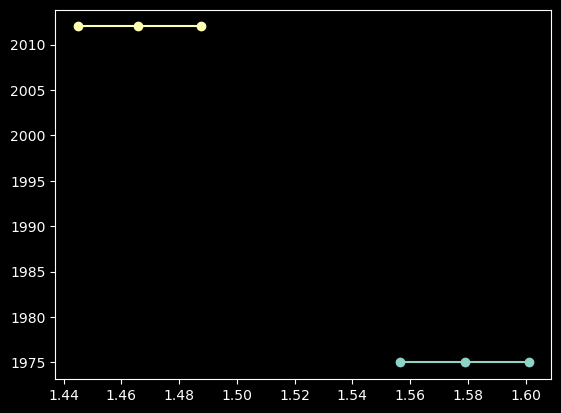

In [317]:
plt.plot([conf_int_1975[0], mean_ratio_1975, conf_int_1975[1]], [1975]*3, marker='o')
plt.plot([conf_int_2012[0], mean_ratio_2012, conf_int_2012[1]], [2012]*3, marker='o')
plt.show()

The mean beak length-to-depth ratio decreased by about 0.1, or 7%, from 1975 to 2012. The 99% confidence intervals are not even close to overlapping, so this is a real change. The beak shape changed.

## Calculation of heritability

### EDA of heritability
The array `bd_parent_scandens` contains the average beak depth (in mm) of two parents of the species G. scandens. The array `bd_offspring_scandens` contains the average beak depth of the offspring of the respective parents. The arrays `bd_parent_fortis` and `bd_offspring_fortis` contain the same information about measurements from G. fortis birds.

In [318]:
scandens = pd.read_csv('scandens_beak_depth_heredity.zip')
scandens['species']='scandens'
scandens

,mid_parent,mid_offspring,species
0,8.3318,8.4190,scandens
1,8.4035,9.2468,scandens
2,8.5317,8.1532,scandens
3,8.7202,8.0089,scandens
4,8.7089,8.2215,scandens
...,...,...,...
125,9.6516,9.4899,scandens
126,9.7572,9.5962,scandens
127,9.8854,9.6873,scandens
128,10.0023,9.5203,scandens


In [319]:
fortis = pd.read_csv('fortis_beak_depth_heredity.zip')
fortis = fortis.rename(columns={'Mid-offspr':'mid_offspring', 'Male BD':'male_bd', 'Female BD':'female_bd'})
fortis['mid_parent'] = fortis[['male_bd', 'female_bd']].mean(axis=1)
fortis['species']='fortis'
fortis

,mid_offspring,male_bd,female_bd,mid_parent,species
0,10.70,10.90,9.3,10.100,fortis
1,9.78,10.70,8.4,9.550,fortis
2,9.48,10.70,8.1,9.400,fortis
3,9.60,10.70,9.8,10.250,fortis
4,10.27,9.85,10.4,10.125,fortis
...,...,...,...,...,...
408,7.70,7.40,9.0,8.200,fortis
409,7.90,7.40,8.3,7.850,fortis
410,9.50,8.85,8.7,8.775,fortis
411,8.20,9.30,7.7,8.500,fortis


In [320]:
geopiza = pd.concat((scandens, fortis), ignore_index=True, sort=False)
geopiza

,mid_parent,mid_offspring,species,male_bd,female_bd
0,8.3318,8.4190,scandens,NaN,NaN
1,8.4035,9.2468,scandens,NaN,NaN
2,8.5317,8.1532,scandens,NaN,NaN
3,8.7202,8.0089,scandens,NaN,NaN
4,8.7089,8.2215,scandens,NaN,NaN
...,...,...,...,...,...
538,8.2000,7.7000,fortis,7.40,9.0
539,7.8500,7.9000,fortis,7.40,8.3
540,8.7750,9.5000,fortis,8.85,8.7
541,8.5000,8.2000,fortis,9.30,7.7


In [327]:
bd_parent_scandens = scandens.mid_parent.values
bd_offspring_scandens = scandens.mid_offspring.values
bd_parent_fortis = fortis.mid_parent.values
bd_offspring_fortis = fortis.mid_offspring.values

Make a scatter plot of the average offspring beak depth (y-axis) versus average parental beak depth (x-axis) for both species. Use the alpha=0.5 keyword argument to help you see overlapping points

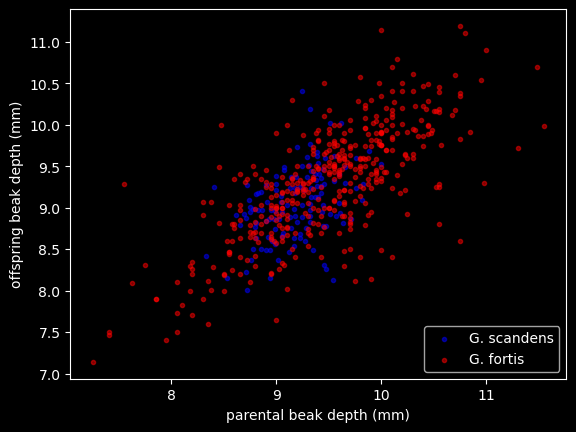

In [330]:
plt.scatter(scandens.mid_parent, scandens.mid_offspring, alpha=0.5, marker='.', color='blue', label='G. scandens')
plt.scatter(fortis.mid_parent, fortis.mid_offspring, alpha=0.5, marker='.', color='red', label='G. fortis')
plt.xlabel('parental beak depth (mm)')
plt.ylabel('offspring beak depth (mm)')
plt.legend(loc='lower right')
plt.show()

It appears as though there is a stronger correlation in G. fortis than in G. scandens.

This suggests that beak depth is more strongly inherited in G. fortis. We'll quantify this correlation next.

/home/mauricio/miniconda3/envs/dev/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


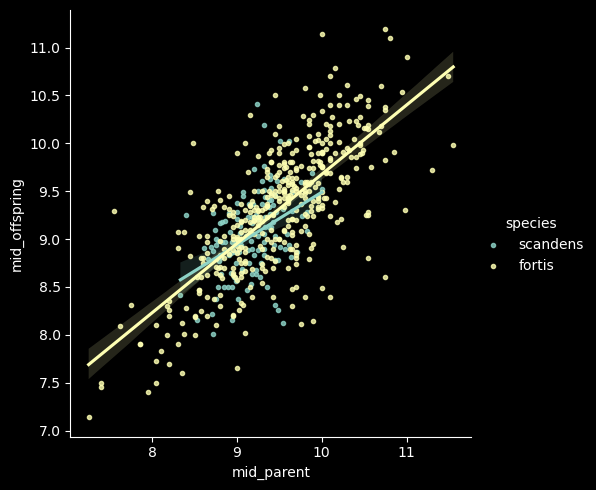

In [333]:
sns.lmplot(data=geopiza, x='mid_parent', y='mid_offspring', hue='species', markers='.')
plt.show()

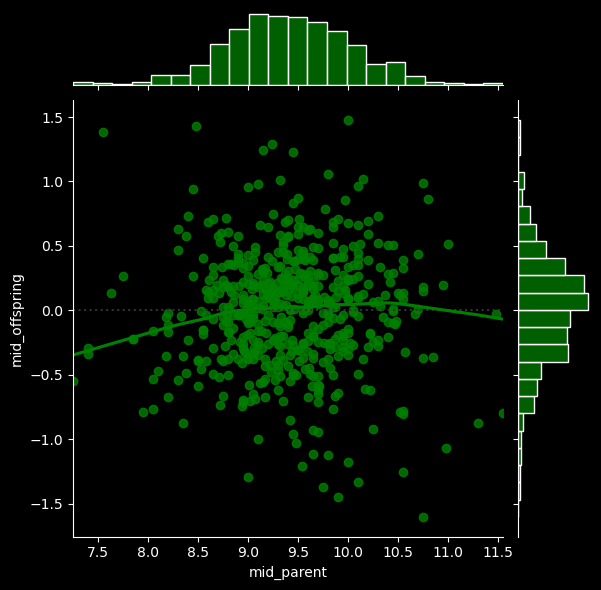

In [337]:
sns.jointplot(data=geopiza, x='mid_parent', y='mid_offspring', kind='resid', color='green', lowess=True)
plt.show()

### Correlation of offspring and parental data
In an effort to quantify the correlation between offspring and parent beak depths, we would like to compute statistics, such as the Pearson correlation coefficient, between parents and offspring. To get confidence intervals on this, we need to do a pairs bootstrap.

You have already written a function to do pairs bootstrap to get estimates for parameters derived from linear regression. Your task in this exercise is to make a new function with call signature `draw_bs_pairs(x, y, func, size=1)` that performs pairs bootstrap and computes a single statistic on pairs samples defined. The statistic of interest is computed by calling `func(bs_x, bs_y)`. In the next exercise, you will use `pearson_r` for `func`.

In [339]:
def draw_bs_pairs(x, y, func, size=1):
    """Perform pairs bootstrap for a single statistic."""
    # Set up array of indices to sample from: inds
    inds = np.arange(len(x))
    # Initialize replicates: bs_replicates
    bs_replicates = np.empty(size)
    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_replicates[i] = func(bs_x, bs_y)
    return bs_replicates

The Pearson correlation coefficient seems like a useful measure of how strongly the beak depth of parents are inherited by their offspring.

Compute the Pearson correlation coefficient between parental and offspring beak depths for G. scandens.

Do the same for G. fortis.

Then, use the function you wrote in the last exercise to compute a 95% confidence interval using pairs bootstrap.

In [343]:
pearson_r = lambda x,y: np.corrcoef(x,y)[0,1]

# Compute the Pearson correlation coefficients
r_scandens = pearson_r(scandens.mid_parent, scandens.mid_offspring)
r_fortis = pearson_r(fortis.mid_parent, fortis.mid_offspring)

# Acquire 1000 bootstrap replicates of Pearson r
bs_replicates_scandens = draw_bs_pairs(scandens.mid_parent, scandens.mid_offspring, pearson_r, 1000)
bs_replicates_fortis = draw_bs_pairs(fortis.mid_parent, fortis.mid_offspring, pearson_r, 1000)

# Compute 95% confidence intervals
conf_int_scandens = np.percentile(bs_replicates_scandens, [2.5, 97.5])
conf_int_fortis = np.percentile(bs_replicates_fortis, [2.5, 97.5])

# Print results
print(f'G. scandens Pearson R:{r_scandens}, C.I.: {conf_int_scandens}')
print(f'G. fortis   Pearson R:{r_fortis}, C.I.: {conf_int_fortis}')

G. scandens Pearson R:0.4117063629401258, C.I.: [0.26333698 0.54736842]
G. fortis   Pearson R:0.7283412395518487, C.I.: [0.67475597 0.78158061]


It is clear from the confidence intervals that beak depth of the offspring of G. fortis parents is more strongly correlated with their offspring than their G. scandens counterparts.

### Measuring heritability
Remember that the Pearson correlation coefficient is the ratio of the covariance to the geometric mean of the variances of the two data sets.

This is a measure of the correlation between parents and offspring, but might not be the best estimate of heritability.

If we stop and think, it makes more sense to define heritability as the ratio of the covariance between parent and offspring to the variance of the parents alone.

In [357]:
def heritability(parents, offspring):
    """Compute the heritability from parent and offspring samples."""
    covariance_matrix = np.cov(parents, offspring)
    return covariance_matrix[0,1] / covariance_matrix[0,0]

In this exercise, you will estimate the heritability and perform a pairs bootstrap calculation to get the 95% confidence interval.

This exercise highlights a very important point: **Statistical inference (and data analysis in general) is not a plug-n-chug enterprise.**

You need to think carefully about the questions you are seeking to answer with your data and analyze them appropriately.

If you are interested in how heritable traits are, the quantity we defined as the heritability is more apt than the off-the-shelf statistic, the Pearson correlation coefficient.

In [360]:
# Compute the heritability
heritability_scandens = heritability(bd_parent_scandens, bd_offspring_scandens)
heritability_fortis = heritability(bd_parent_fortis, bd_offspring_fortis)

# Acquire 1000 bootstrap replicates of heritability
replicates_scandens = draw_bs_pairs(bd_parent_scandens, bd_offspring_scandens, heritability, size=1000)
replicates_fortis = draw_bs_pairs(bd_parent_fortis, bd_offspring_fortis, heritability, size=1000)

# Compute 95% confidence intervals
conf_int_scandens = np.percentile(replicates_scandens, [2.5, 97.5])
conf_int_fortis = np.percentile(replicates_fortis, [2.5, 97.5])

# Print results
print(f'G. scandens heritability:{heritability_scandens}, C.I.: {conf_int_scandens}')
print(f'G. fortis   heritability:{heritability_fortis}, C.I.: {conf_int_fortis}')

G. scandens heritability:0.5485340868685982, C.I.: [0.34751217 0.74081088]
G. fortis   heritability:0.7229051911438159, C.I.: [0.64540788 0.79647361]


Here again, we see that G. fortis has stronger heritability than G. scandens.

This suggests that the traits of G. fortis may be strongly incorporated into G. scandens by introgressive hybridization.

### Is beak depth heritable at all in G. scandens?
The heritability of beak depth in G. scandens seems low. It could be that this observed heritability was just achieved by chance and beak depth is actually not really heritable in the species. You will test that hypothesis here. To do this, you will do a pairs permutation test.

In [361]:
# Initialize array of replicates: perm_replicates
perm_replicates = np.empty(10000)

# Draw replicates
for i in range(10000):
    # Permute parent beak depths
    bd_parent_permuted = np.random.permutation(bd_parent_scandens)
    perm_replicates[i] = heritability(bd_parent_permuted, bd_offspring_scandens)


# Compute p-value: p
np.mean(perm_replicates > heritability_scandens)

0.0

You get a p-value of zero, which means that none of the 10,000 permutation pairs replicates you drew had a heritability high enough to match that which was observed. This strongly suggests that beak depth is heritable in G. scandens, just not as much as in G. fortis

If you like, you can plot a histogram of the heritability replicates to get a feel for how extreme of a value of heritability you might expect by chance.

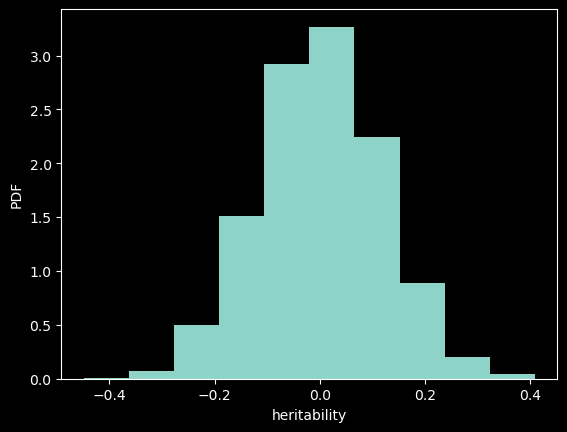

In [362]:
plt.hist(perm_replicates, density=True)
plt.xlabel('heritability')
plt.ylabel('PDF')
plt.show()